# RIDE SHARE REVENUE ANALYSIS AND PREDICTION
Take-home Data Challenge  
**Eseose Okiti**

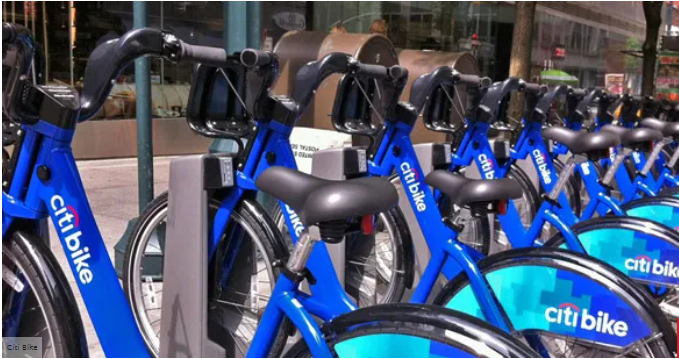


**Introduction**  
A bike share service rents out bicycles on a short-term basis to customers for a fee. The bicycles taken from a particular station can be returned to any other station in the system.

This data challenge requires us to forecast the daily revenue for a set of stations in a bike share system in Austin, TX. We are given the bike trip data for every public trip in the system and the daily weather data for the city.


**Task**  
Using the provided data, we would like you to predict the amount of daily per-station revenue generated by trips <u>started</u> from a specific set of 10 stations in the months of January, March, July, and October of 2016 (each month being roughly representative of a season).

You should assume that for each ride, users are charged $1.00 + $0.10 per minute the ride lasts. For example, if a ride lasts 20 minutes, the fee paid by the user is $3.00.


In [47]:
!pip install neuralprophet[live]

  Using cached neuralprophet-0.3.2-py3-none-any.whl (74 kB)


In [48]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from seaborn import palettes
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
set_random_seed(0)

# Exploratory Data Analysis

## Prediction Data
For now, we just need to extract the 10 stations this challenge would be predicting revenue for and save it as a list we can always refer to. 

In [4]:
#Creating a dataframe from the given csv file and naming the columns
predictions = pd.read_csv('predictions.csv')
predictions

,1,1.1,17th & Guadalupe,-1
0,1,1,2nd & Congress,-1
1,1,1,5th & Bowie,-1
2,1,1,8th & Congress,-1
3,1,1,City Hall / Lavaca & 2nd,-1
4,1,1,Convention Center / 3rd & Trinity,-1
...,...,...,...,...
1234,10,31,Convention Center / 3rd & Trinity,-1
1235,10,31,Davis at Rainey Street,-1
1236,10,31,Guadalupe & 21st,-1
1237,10,31,South Congress & Academy,-1


In [5]:
#Extracting the stations needed.
stations = predictions['17th & Guadalupe'].unique()
stations

array(['2nd & Congress', '5th & Bowie', '8th & Congress',
       'City Hall / Lavaca & 2nd', 'Convention Center / 3rd & Trinity',
       'Davis at Rainey Street', 'Guadalupe & 21st',
       'South Congress & Academy', 'West & 6th St.', '17th & Guadalupe'],
      dtype=object)

## Bike Trip Data

In [6]:
#Converting data file into a dataframe
df_bike_orig = pd.read_csv('bike_trip_data.csv')
df_bike_orig

,month,day,year,start_time,duration_minutes,bikeid,start_station_id,start_station_name,end_station_id,end_station_name
0,1,1,2014,0:12,20,428.0,2495.0,4th & Congress,2502.0,Barton Springs & Riverside
1,1,1,2014,0:12,19,14.0,2495.0,4th & Congress,2502.0,Barton Springs & Riverside
2,1,1,2014,0:12,17,172.0,2495.0,4th & Congress,2502.0,Barton Springs & Riverside
3,1,1,2014,0:12,8,417.0,2498.0,Convention Center / 4th St. @ MetroRail,2498.0,Convention Center / 4th St. @ MetroRail
4,1,1,2014,2:12,15,40.0,2496.0,8th & Congress,2503.0,South Congress & James
...,...,...,...,...,...,...,...,...,...,...
328665,12,31,2015,23:12,11,52.0,2501.0,5th & Bowie,1008.0,Nueces @ 3rd
328666,12,31,2015,23:12,10,995.0,2501.0,5th & Bowie,1008.0,Nueces @ 3rd
328667,12,31,2015,23:12,6,545.0,2501.0,5th & Bowie,1007.0,Lavaca & 6th
328668,12,31,2015,23:12,5,445.0,2501.0,5th & Bowie,1007.0,Lavaca & 6th


In [7]:
# Checking for the amount of empty cells in each column
# Columns with null values are not important so we can procede
df_bike_orig.isnull().sum()

month                     0
day                       0
year                      0
start_time                0
duration_minutes          0
bikeid                  545
start_station_id      17451
start_station_name        0
end_station_id        18188
end_station_name          0
dtype: int64

In [8]:
#Checking for data types in each column
df_bike_orig.dtypes

month                   int64
day                     int64
year                    int64
start_time             object
duration_minutes        int64
bikeid                float64
start_station_id      float64
start_station_name     object
end_station_id        float64
end_station_name       object
dtype: object

In [9]:
# Create the revenue column using Given Formula:
# revenue = 1.00 + 0.10 * duration_minutes
revenue = 1.00 + 0.10 * df_bike_orig["duration_minutes"]
revenue.head()

0    3.0
1    2.9
2    2.7
3    1.8
4    2.5
Name: duration_minutes, dtype: float64

In [10]:
# Insert the revenue column into df_bike
df_bike_orig.insert(5, 'revenue', revenue)
df_bike_orig.head(1)

,month,day,year,start_time,duration_minutes,revenue,bikeid,start_station_id,start_station_name,end_station_id,end_station_name
0,1,1,2014,0:12,20,3.0,428.0,2495.0,4th & Congress,2502.0,Barton Springs & Riverside


In [11]:
# Creating a date column by merging month, day, year
# New date column is set to a datetime object
date = pd.to_datetime(df_bike_orig[['month','day','year']])
#Inserting date column into df_bike
df_bike_orig.insert(0, 'date', date)
df_bike_orig.tail(1)

,date,month,day,year,start_time,duration_minutes,revenue,bikeid,start_station_id,start_station_name,end_station_id,end_station_name
328669,2015-12-31,12,31,2015,23:12,10,2.0,301.0,2547.0,Guadalupe & 21st,1007.0,Lavaca & 6th


In [12]:
#Creating a copy we can adapt to our analysis
df_bike = df_bike_orig
df_bike.head(1)

,date,month,day,year,start_time,duration_minutes,revenue,bikeid,start_station_id,start_station_name,end_station_id,end_station_name
0,2014-01-01,1,1,2014,0:12,20,3.0,428.0,2495.0,4th & Congress,2502.0,Barton Springs & Riverside


In [13]:
# Dropping columns for a better view
df_bike = df_bike[['date', 'month', 'day', 'year', 'revenue', 'start_station_name']]
df_bike.tail(1)

,date,month,day,year,revenue,start_station_name
328669,2015-12-31,12,31,2015,2.0,Guadalupe & 21st


In [14]:
# Checking the duration of our data: 2 years
df_bike.year.unique()

array([2014, 2015], dtype=int64)

In [15]:
# Checking for unique start_station_names: 74 names
df_bike['start_station_name'].value_counts()

City Hall / Lavaca & 2nd      16373
5th & Bowie                   15369
4th & Congress                14448
Riverside @ S. Lamar          14079
2nd & Congress                13914
                              ...  
Re-branding                       6
Marketing Event                   4
Mobile Station @ Unplugged        4
Customer Service                  4
East 7th & Pleasant Valley        2
Name: start_station_name, Length: 74, dtype: int64

In [16]:
#Grouping the data to sum up daily revenue for each station
df_bike = df_bike.groupby(by=['year','month','day','date','start_station_name'], as_index=False).sum()
df_bike

,year,month,day,date,start_station_name,revenue
0,2014,1,1,2014-01-01,2nd & Congress,115.9
1,2014,1,1,2014-01-01,4th & Congress,94.9
2,2014,1,1,2014-01-01,5th & Bowie,100.8
3,2014,1,1,2014-01-01,8th & Congress,129.6
4,2014,1,1,2014-01-01,Barton Springs & Riverside,139.8
...,...,...,...,...,...,...
28986,2015,12,31,2015-12-31,Trinity & 6th Street,13.6
28987,2015,12,31,2015-12-31,UT West Mall @ Guadalupe,23.2
28988,2015,12,31,2015-12-31,Waller & 6th St.,25.2
28989,2015,12,31,2015-12-31,West & 6th St.,4.4


In [17]:
#Total daily revenue
df_bike_daily_revenue = df_bike.groupby(by=['year','month','day','date'], as_index=False).sum()
df_bike_daily_revenue

,year,month,day,date,revenue
0,2014,1,1,2014-01-01,1377.3
1,2014,1,2,2014-01-02,443.5
2,2014,1,3,2014-01-03,301.1
3,2014,1,4,2014-01-04,838.0
4,2014,1,5,2014-01-05,128.5
...,...,...,...,...,...
724,2015,12,27,2015-12-27,190.0
725,2015,12,28,2015-12-28,382.5
726,2015,12,29,2015-12-29,930.9
727,2015,12,30,2015-12-30,1909.3


<AxesSubplot:title={'center':'Daily Revenue Plot'}, xlabel='Date', ylabel='Daily Revenue'>

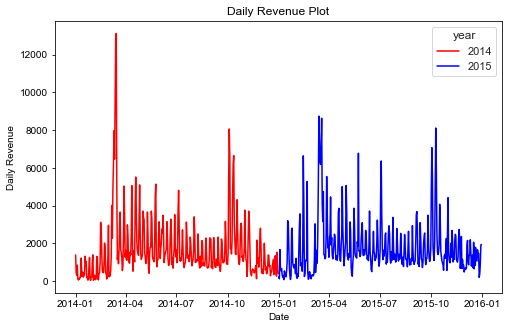

In [18]:
#Plotting the total daily revenue
df = df_bike_daily_revenue
#segment by year
df1 = df[df['date'].dt.year==2014]
df2 = df[df['date'].dt.year==2015]

plt.figure(figsize = (8,5))
plt.xlabel('Date')
plt.ylabel('Daily Revenue')
plt.title('Daily Revenue Plot')

months1=df1['date'].dt.month_name().str[:3]
months2=df2['date'].dt.month_name().str[:3]

sns.set(style='white', palette='pastel')

sns.lineplot(x='date', y='revenue', hue='year', palette=['red'], data=df1, ci=False)
sns.lineplot(x='date', y='revenue', hue='year', palette=['blue'], data=df2, ci=False)
    

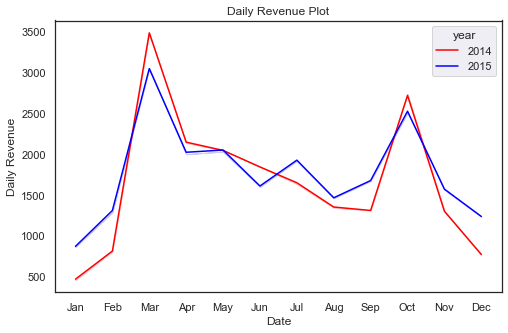

In [19]:
#Plotting the total daily revenue
def plot_yearly(df, year1, year2=None):
    #segment by year
    df1 = df[df['date'].dt.year==year1]
    df2 = df[df['date'].dt.year==year2]
    
    plt.figure(figsize = (8,5))
    plt.xlabel('Date')
    plt.ylabel('Daily Revenue')
    plt.title('Daily Revenue Plot')

    months1=df1['date'].dt.month_name().str[:3]
    months2=df2['date'].dt.month_name().str[:3]

    sns.set(style='dark', palette='pastel')

    sns.lineplot(x=months1, y='revenue', hue='year', palette=['red'], data=df1, ci=False)
    sns.lineplot(x=months2, y='revenue', hue='year', palette=['blue'], data=df2, ci=False)

plot_yearly(df_bike_daily_revenue, 2014, 2015)

**Insights**   
Plotting both years in a stack shows the yearly seasonality in the revenue. The following points can be understood from this plot:
1. Lowest monthly revenue occurs in January corresponding to winter in Austin, Tx. 
2. The revenue climbs in spring with the highest monthly revenue occuring in the month of March. 
3. There is a drop as spring transitions to the summer months. 
4. October shows a steep rise in revenue compared to September and November.

In [20]:
#Total monthly revenue
df_bike_monthly_revenue = df_bike_orig[['year','month','day','revenue']]
df_bike_monthly_revenue = df_bike_monthly_revenue.groupby(by=['year','month'], as_index=False).sum()
df_bike_monthly_revenue = df_bike_monthly_revenue.rename(columns={'day':'no_of_rides'})
df_bike_monthly_revenue

,year,month,no_of_rides,revenue
0,2014,1,52053,14555.9
1,2014,2,90085,22758.8
2,2014,3,389375,107776.7
3,2014,4,240488,64273.2
4,2014,5,242622,63288.5
5,2014,6,198712,55188.8
6,2014,7,203873,51059.1
7,2014,8,159934,40511.6
8,2014,9,182681,39258.1
9,2014,10,303618,84113.6


<Figure size 576x360 with 0 Axes>

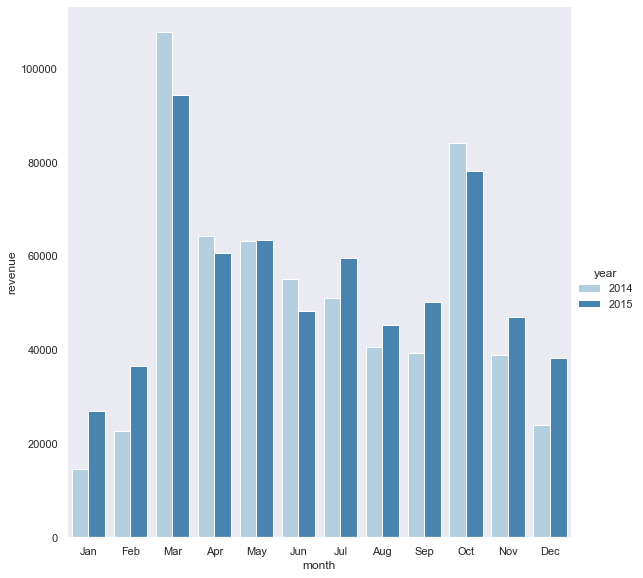

In [21]:
#Comparing total monthly revenue
df=df_bike_monthly_revenue
df['month']=pd.to_datetime(df['month'], format='%m').dt.month_name().str[:3]

plt.figure(figsize = (8,5))

sns.catplot(x='month', y='revenue', hue='year',palette='Blues', 
            data=df, kind='bar', ci=False, height = 8)

In [22]:
#Creating a dataframe for a specific start_station: '5th & Bowie'
df_bike_5thB = df_bike[df_bike['start_station_name'] == '5th & Bowie'].reset_index(drop=True)
df_bike_5thB

,year,month,day,date,start_station_name,revenue
0,2014,1,1,2014-01-01,5th & Bowie,100.8
1,2014,1,2,2014-01-02,5th & Bowie,27.3
2,2014,1,3,2014-01-03,5th & Bowie,40.9
3,2014,1,4,2014-01-04,5th & Bowie,91.1
4,2014,1,5,2014-01-05,5th & Bowie,8.5
...,...,...,...,...,...,...
721,2015,12,27,2015-12-27,5th & Bowie,7.6
722,2015,12,28,2015-12-28,5th & Bowie,13.4
723,2015,12,29,2015-12-29,5th & Bowie,20.1
724,2015,12,30,2015-12-30,5th & Bowie,118.2


In [23]:
#Creating a function to plot daily revenue for each station
def plotStation(station: str, year1, year2=None):
    df_bike_station = df_bike[df_bike['start_station_name'] == station]
    df_bike_station = df_bike_station[['date','year', 'month', 'revenue','start_station_name']]
    df_bike_station_year = df_bike_station
    
    #Changing the values in month column from numeric to categorical
    df_bike_station_year['month']=df_bike_station_year['date'].dt.month_name().str[:3]
    
    # If year 2 is None or year 1 has a smaller min_month than year2,
    year1_data = df_bike_station_year[df_bike_station_year['date'].dt.year==year1]
    year2_data = df_bike_station_year[df_bike_station_year['date'].dt.year==year2]
    df_bike_station_year1 = df_bike_station_year[df_bike_station_year['date'].dt.year==year1]
    df_bike_station_year2 = df_bike_station_year[df_bike_station_year['date'].dt.year==year2]

    # year2 is not none and year 2 has a smaller min_month than year_1, we should swap
    if year2 is not None and min(year1_data['month']) > min(year2_data['month']):
        df_bike_station_year1 = df_bike_station_year[df_bike_station_year['date'].dt.year==year2]
        df_bike_station_year2 = df_bike_station_year[df_bike_station_year['date'].dt.year==year1]

    plt.figure(figsize = (10,8))
    plt.xlabel('Date')
    plt.ylabel('Daily Revenue')
    Title = 'Daily Revenue Over Time for {} in the year {} and year {}'.format(station,year1,year2)
    plt.title(Title)
    
    sns.set_theme(style="white")
    sns.lineplot(x='month',y='revenue',hue='year',palette=['red'],data=df_bike_station_year1,ci=None)
    sns.lineplot(x='month',y='revenue',hue='year',palette=['blue'],data=df_bike_station_year2,ci=None)

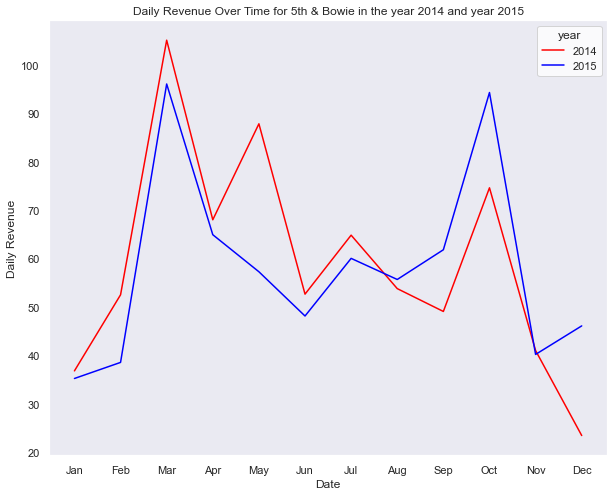

In [24]:
plotStation('5th & Bowie', 2014, 2015)

## Weather Data

In [25]:
#Creating a dataframe from weather data.
df_weather  = pd.read_csv('weather_data.csv')
df_weather

,Date,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Events
0,1/1/14,69,54,39,83,68,52,10,10,8,13,4,22,0,NaN
1,1/2/14,55,44,33,83,55,26,10,10,9,21,8,31,0,NaN
2,1/3/14,58,43,28,75,49,22,10,10,10,14,4,21,0,NaN
3,1/4/14,71,57,42,89,68,47,10,10,8,16,7,28,0,NaN
4,1/5/14,59,47,34,87,59,31,10,10,4,21,10,34,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,12/27/16,76,69,62,97,72,46,10,10,10,7,1,11,T,NaN
1092,12/28/16,83,73,62,93,72,51,10,9,4,12,3,20,0,NaN
1093,12/29/16,70,60,49,84,51,18,10,10,10,18,9,30,0,NaN
1094,12/30/16,55,52,49,48,38,27,10,10,10,12,4,16,T,NaN


In [26]:
#Setting the column date to datetime series
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather.head(1)

,Date,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Events
0,2014-01-01,69,54,39,83,68,52,10,10,8,13,4,22,0,NaN


In [27]:
#Checking column data types
df_weather.dtypes

Date                    datetime64[ns]
TempHigh_F                       int64
TempAvg_F                        int64
TempLow_F                        int64
HumidityHigh_Percent            object
HumidityAvg_Percent             object
HumidityLow_Percent             object
VisibilityHigh_Miles            object
VisibilityAvg_Miles             object
VisibilityLow_Miles             object
WindHigh_MPH                    object
WindAvg_MPH                     object
WindGust_MPH                    object
Precipitation_Inches            object
Events                          object
dtype: object

In [28]:
#Checking for null values
df_weather.isnull().sum()

Date                      0
TempHigh_F                0
TempAvg_F                 0
TempLow_F                 0
HumidityHigh_Percent      0
HumidityAvg_Percent       0
HumidityLow_Percent       0
VisibilityHigh_Miles      0
VisibilityAvg_Miles       0
VisibilityLow_Miles       0
WindHigh_MPH              0
WindAvg_MPH               0
WindGust_MPH              0
Precipitation_Inches      0
Events                  744
dtype: int64

**Events**  
From weather_data_readme.txt, Events column contains a list of adverse weather events, if any. We have to change these categorical variables to numeric variables to prepare it for our algorithm. 

One-hot Encoding is a method of representing categorical variables as binary vectors.

In [29]:
#Checking the unique elements in events
df_weather['Events'].value_counts()

Rain                     167
Rain,Thunderstorm        108
Fog,Rain,Thunderstorm     31
Fog                       18
Fog,Rain                  13
Thunderstorm              13
Fog,Thunderstorm           1
Rain,Snow                  1
Name: Events, dtype: int64

In [30]:
#Changing Events from categorical to numeric variables
new_Events = df_weather['Events'].str.split(' , ', expand = True).stack()
new_Events = df_weather['Events'].str.split(',', expand = True).stack()
new_Events.tail(10)

1067  0    Rain
1068  0    Rain
1069  0    Rain
1070  0     Fog
1075  0     Fog
      1    Rain
1087  0     Fog
      1    Rain
1090  0    Rain
1095  0    Rain
dtype: object

In [31]:
# Creating a dataframe
events = pd.get_dummies(new_Events).groupby(level=0).sum()
events.columns

Index(['Fog', 'Rain', 'Snow', 'Thunderstorm'], dtype='object')

In [32]:
# Adding the events columns to the weather data
df_weather = df_weather.join(events)
df_weather.columns

Index(['Date', 'TempHigh_F', 'TempAvg_F', 'TempLow_F', 'HumidityHigh_Percent',
       'HumidityAvg_Percent', 'HumidityLow_Percent', 'VisibilityHigh_Miles',
       'VisibilityAvg_Miles', 'VisibilityLow_Miles', 'WindHigh_MPH',
       'WindAvg_MPH', 'WindGust_MPH', 'Precipitation_Inches', 'Events', 'Fog',
       'Rain', 'Snow', 'Thunderstorm'],
      dtype='object')

In [33]:
#Filling null values with 0, since 0 means the event did not occur.
df_weather[['Events','Fog','Rain','Snow','Thunderstorm']] = df_weather[
    ['Events','Fog','Rain', 'Snow', 'Thunderstorm']].fillna(0)
df_weather.isnull().sum()

Date                    0
TempHigh_F              0
TempAvg_F               0
TempLow_F               0
HumidityHigh_Percent    0
HumidityAvg_Percent     0
HumidityLow_Percent     0
VisibilityHigh_Miles    0
VisibilityAvg_Miles     0
VisibilityLow_Miles     0
WindHigh_MPH            0
WindAvg_MPH             0
WindGust_MPH            0
Precipitation_Inches    0
Events                  0
Fog                     0
Rain                    0
Snow                    0
Thunderstorm            0
dtype: int64

In [34]:
# Cell check
df_weather.loc[df_weather['Date']=='08/11/15']

,Date,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Events,Fog,Rain,Snow,Thunderstorm
587,2015-08-11,105,90,75,-,-,-,-,-,-,-,-,-,0,0,0.0,0.0,0.0,0.0


In [35]:
#Replacing all '-' values with null in dataframe
df_weather = df_weather.replace('-',  float('nan'))

#cell check
df_weather.loc[df_weather['Date']=='08/11/15']   

,Date,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Events,Fog,Rain,Snow,Thunderstorm
587,2015-08-11,105,90,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.0,0.0,0.0,0.0


**Trace in Precipitation**   
Trace precipitation (T) means a very small amount, greater than zero but not enough to measure. Note that the sum of all trace precipitaions in a day remains equal to a trace amount, hence trace precipitation has no accumulation. Visible evidence of which is usually damp surfaces.

T = 0.00 in inches if it must be a numerical value (https://www.thoughtco.com/what-is-trace-of-precipitation-3444238).

In [36]:
#Giving a numerical value to trace precipitation
df_weather['Precipitation_Inches'] = df_weather['Precipitation_Inches'].replace('T', 0.00)
df_weather.tail(5)

,Date,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Events,Fog,Rain,Snow,Thunderstorm
1091,2016-12-27,76,69,62,97,72,46,10,10,10,7,1,11,0.0,0,0.0,0.0,0.0,0.0
1092,2016-12-28,83,73,62,93,72,51,10,9,4,12,3,20,0,0,0.0,0.0,0.0,0.0
1093,2016-12-29,70,60,49,84,51,18,10,10,10,18,9,30,0,0,0.0,0.0,0.0,0.0
1094,2016-12-30,55,52,49,48,38,27,10,10,10,12,4,16,0.0,0,0.0,0.0,0.0,0.0
1095,2016-12-31,77,64,51,90,70,50,10,10,4,10,3,18,0.0,Rain,0.0,1.0,0.0,0.0


In [37]:
#Error invalid literal for int() with base 10: '-' from astype(float)
#Convert to type float as numeric variables are needed for modeling
df_weather[['HumidityHigh_Percent','HumidityAvg_Percent','HumidityLow_Percent',
            'VisibilityHigh_Miles','VisibilityAvg_Miles','VisibilityLow_Miles',
            'WindHigh_MPH','WindAvg_MPH','WindGust_MPH','Precipitation_Inches'
            ]]=df_weather[[
                           'HumidityHigh_Percent','HumidityAvg_Percent',
                           'HumidityLow_Percent','VisibilityHigh_Miles',
                           'VisibilityAvg_Miles','VisibilityLow_Miles',
                           'WindHigh_MPH','WindAvg_MPH','WindGust_MPH',
                           'Precipitation_Inches'
                           ]].astype(float)

df_weather.dtypes

Date                    datetime64[ns]
TempHigh_F                       int64
TempAvg_F                        int64
TempLow_F                        int64
HumidityHigh_Percent           float64
HumidityAvg_Percent            float64
HumidityLow_Percent            float64
VisibilityHigh_Miles           float64
VisibilityAvg_Miles            float64
VisibilityLow_Miles            float64
WindHigh_MPH                   float64
WindAvg_MPH                    float64
WindGust_MPH                   float64
Precipitation_Inches           float64
Events                          object
Fog                            float64
Rain                           float64
Snow                           float64
Thunderstorm                   float64
dtype: object

In [38]:
df_weather.describe()

,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm
count,1096.000000,1096.000000,1096.000000,1094.000000,1094.000000,1094.000000,1084.000000,1084.000000,1084.000000,1094.000000,1094.000000,1093.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,80.449818,70.354927,59.733577,88.205667,67.225777,45.768739,9.990775,9.119004,6.748155,13.095064,4.943327,21.086917,0.122600,0.057482,0.291971,0.000912,0.139599
std,14.901051,14.210901,14.383851,10.971756,12.543328,17.189182,0.176944,1.500277,3.708472,3.442391,2.100078,5.886810,0.457093,0.232867,0.454877,0.030206,0.346728
min,32.000000,29.000000,22.000000,37.000000,27.000000,10.000000,5.000000,2.000000,0.000000,6.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,71.000000,61.000000,49.000000,85.000000,60.000000,33.000000,10.000000,9.000000,3.000000,10.000000,3.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,83.000000,73.000000,63.000000,91.000000,68.000000,44.000000,10.000000,10.000000,9.000000,13.000000,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,92.000000,83.000000,73.000000,94.000000,75.000000,56.000000,10.000000,10.000000,10.000000,15.000000,6.000000,25.000000,0.010000,0.000000,1.000000,0.000000,0.000000
max,105.000000,92.000000,81.000000,100.000000,97.000000,93.000000,10.000000,10.000000,10.000000,29.000000,12.000000,57.000000,5.200000,1.000000,1.000000,1.000000,1.000000


**Temperature**  
Studies by doctors say the following about environmental temperature:

Highs in range(90, 105) results in heat cramps and exhaustion.
Highs in range(105, 130) results in heat exhaustion: limit activities.
Over 130_F leads to heat stroke.
(https://www.healthline.com/health/extreme-temperature-safety#extreme-heat-temperatures)

Lows at or below 32_F can lead to frost bites.
(https://www.verywellhealth.com/frostbite-and-other-cold-weather-foot-conditions-1337761#:~:text=Frostbite%20can%20occur%20with%20exposure,varying%20degrees%20of%20skin%20damage.)

<u>Data:</u>
Max Temp is 105 and min Temp is 22.


In [39]:
# Finding where highest temp occurs
df_weather.loc[df_weather['TempHigh_F']==105]

,Date,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Events,Fog,Rain,Snow,Thunderstorm
586,2015-08-10,105,90,74,100.0,62.0,24.0,NaN,NaN,NaN,14.0,6.0,20.0,0.0,0,0.0,0.0,0.0,0.0
587,2015-08-11,105,90,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0.0,0.0,0.0,0.0
588,2015-08-12,105,92,79,55.0,43.0,31.0,10.0,10.0,10.0,13.0,3.0,20.0,0.0,0,0.0,0.0,0.0,0.0
954,2016-08-12,105,92,79,91.0,63.0,35.0,10.0,10.0,9.0,15.0,5.0,24.0,0.0,0,0.0,0.0,0.0,0.0


In [40]:
#Filling NaN values with fill forward method
df_weather = df_weather.fillna(method='ffill',axis=0)
df_weather.iloc[587,4]

100.0

In [41]:
df_weather.isnull().sum()

Date                    0
TempHigh_F              0
TempAvg_F               0
TempLow_F               0
HumidityHigh_Percent    0
HumidityAvg_Percent     0
HumidityLow_Percent     0
VisibilityHigh_Miles    0
VisibilityAvg_Miles     0
VisibilityLow_Miles     0
WindHigh_MPH            0
WindAvg_MPH             0
WindGust_MPH            0
Precipitation_Inches    0
Events                  0
Fog                     0
Rain                    0
Snow                    0
Thunderstorm            0
dtype: int64

In [42]:
#Find the range of years in the dataset
df_weather['Date'].dt.year.value_counts()

2016    366
2014    365
2015    365
Name: Date, dtype: int64

## Merged Weather and Bike Trip Data

In [43]:
#Preparing bike trip data 
df = df_bike[['year','date','month','revenue']]
df = df.rename(columns={'revenue':'Revenue', 'date':'Date'})
df = df.groupby(by=['year','month','Date'], as_index=False).sum()
df_revenue = df[['Date','Revenue']]
#Preparing weather data
df_weather = df_weather.drop('Events', axis=1)
# Merging with weather data for 2014 and 2015
df_merged = df_weather.merge(df_revenue, how='inner')
df_merged

,Date,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,Revenue
0,2014-01-01,69,54,39,83.0,68.0,52.0,10.0,10.0,8.0,13.0,4.0,22.0,0.00,0.0,0.0,0.0,0.0,1377.3
1,2014-01-02,55,44,33,83.0,55.0,26.0,10.0,10.0,9.0,21.0,8.0,31.0,0.00,0.0,0.0,0.0,0.0,443.5
2,2014-01-03,58,43,28,75.0,49.0,22.0,10.0,10.0,10.0,14.0,4.0,21.0,0.00,0.0,0.0,0.0,0.0,301.1
3,2014-01-04,71,57,42,89.0,68.0,47.0,10.0,10.0,8.0,16.0,7.0,28.0,0.00,0.0,0.0,0.0,0.0,838.0
4,2014-01-05,59,47,34,87.0,59.0,31.0,10.0,10.0,4.0,21.0,10.0,34.0,0.00,0.0,0.0,0.0,0.0,128.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2015-12-27,73,55,36,93.0,89.0,84.0,10.0,8.0,1.0,21.0,10.0,33.0,1.32,0.0,1.0,0.0,1.0,190.0
725,2015-12-28,46,41,36,92.0,75.0,58.0,10.0,10.0,10.0,21.0,8.0,35.0,0.00,0.0,0.0,0.0,0.0,382.5
726,2015-12-29,49,43,37,92.0,74.0,56.0,10.0,8.0,3.0,8.0,3.0,11.0,0.03,0.0,1.0,0.0,0.0,930.9
727,2015-12-30,57,49,41,100.0,80.0,59.0,10.0,7.0,3.0,9.0,4.0,14.0,0.00,0.0,1.0,0.0,0.0,1909.3


<AxesSubplot:>

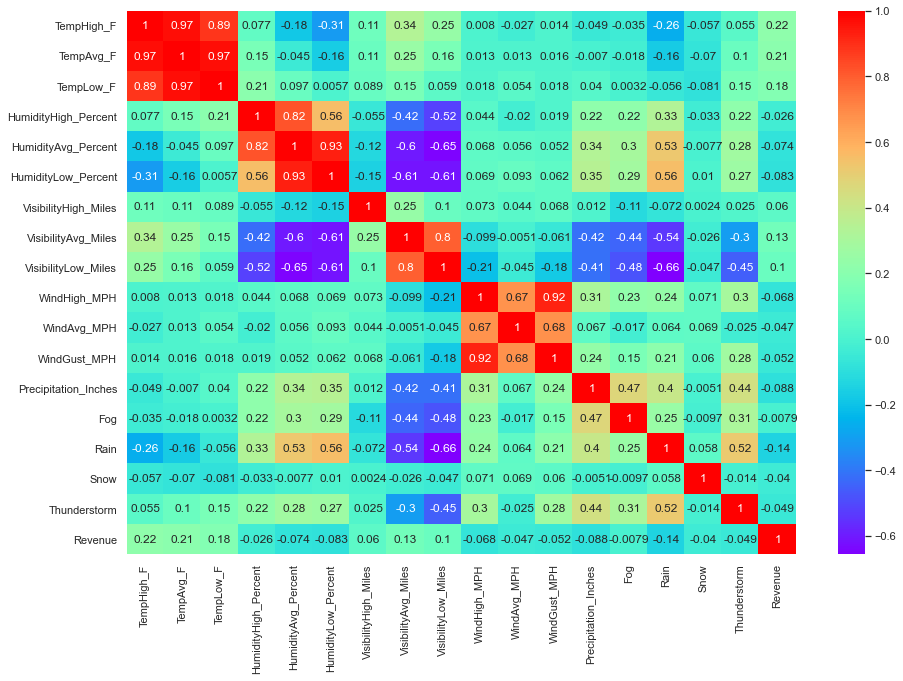

In [44]:
#Find the correlation between variables in weather data
#Very low correlation between variables in distinct sectors e.g 3 Temp columns
plt.figure(figsize=(15,10))
sns.heatmap(df_merged.corr(), annot=True, cmap='rainbow')

<ipython-input-45-a3c1db5f6510>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['TempHigh_F']=norm(df1['TempHigh_F'])
<ipython-input-45-a3c1db5f6510>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['VisibilityAvg_Miles']=norm(df1['VisibilityAvg_Miles'])
<ipython-input-45-a3c1db5f6510>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

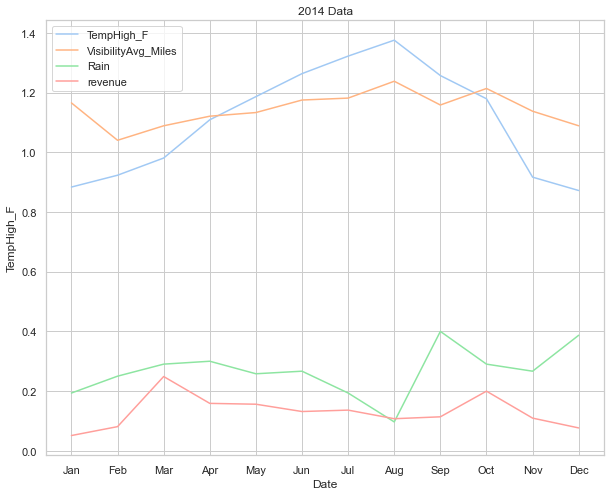

In [45]:
#Normalizing the data to visualize Revenue, VisibilityAvg_Miles, Rain and TempHigh_F
def norm(data):
    return (data)/(max(data)-min(data)) 
#weather data
df=df_weather
df['Month']=df['Date'].dt.month_name().str[:3]
df['Year']=df['Date'].dt.year
df1=df[df['Year']==2014]
df1['TempHigh_F']=norm(df1['TempHigh_F'])
df1['VisibilityAvg_Miles']=norm(df1['VisibilityAvg_Miles'])
df1['Rain']=norm(df1['Rain'])
#bike trip data
df_b = df_bike_daily_revenue
df_b['month'] = df_b['date'].dt.month_name().str[:3]
df_b['revenue']=norm(df_b['revenue'])
# df2 = df_b[df_b['date'].dt.strftime('%Y')==2014]
#Setting plot s
sns.set_theme(style= 'whitegrid', palette='pastel')
plt.figure(figsize = (10,8))
plt.xlabel('Date')
plt.title('2014 Data')

sns.lineplot(x='Month',y='TempHigh_F',legend='full',data=df1,ci=None)
sns.lineplot(x='Month',y='VisibilityAvg_Miles',legend='full',data=df1,ci=None)
sns.lineplot(x='Month',y='Rain',legend='full',data=df1,ci=None)
sns.lineplot(x='month',y='revenue',legend='full',data=df_b,ci=None)

plt.legend(labels=['TempHigh_F','VisibilityAvg_Miles','Rain','revenue'])

<ipython-input-46-6e6f70e4c37e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['TempHigh_F']=norm(df1['TempHigh_F'])
<ipython-input-46-6e6f70e4c37e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['VisibilityAvg_Miles']=norm(df1['VisibilityAvg_Miles'])
<ipython-input-46-6e6f70e4c37e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

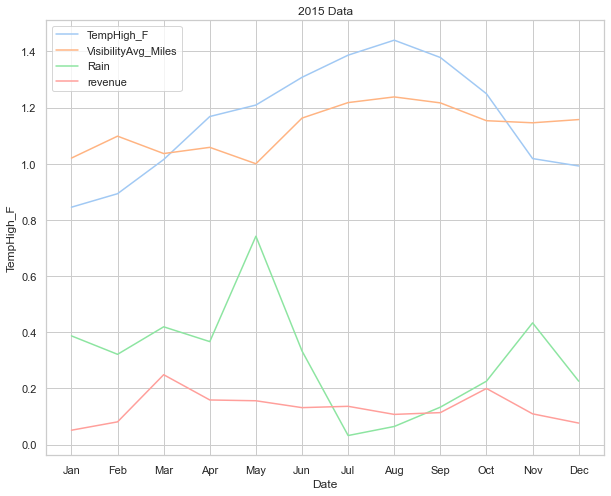

In [46]:
#Normalizing the data to visualize Revenue, VisibilityAvg_Miles, Rain and TempHigh_F
def norm(data):
    return (data)/(max(data)-min(data)) 
#weather data
df=df_weather
df['Month']=df['Date'].dt.month_name().str[:3]
df['Year']=df['Date'].dt.year
df1=df[df['Year']==2015]
df1['TempHigh_F']=norm(df1['TempHigh_F'])
df1['VisibilityAvg_Miles']=norm(df1['VisibilityAvg_Miles'])
df1['Rain']=norm(df1['Rain'])
#bike trip data
df_b = df_bike_daily_revenue
df_b['month'] = df_b['date'].dt.month_name().str[:3]
df_b['revenue']=norm(df_b['revenue'])

#Setting plot 
sns.set_theme(style= 'whitegrid', palette='pastel')
plt.figure(figsize = (10,8))
plt.xlabel('Date')
plt.title('2015 Data')

sns.lineplot(x='Month',y='TempHigh_F',legend='full',data=df1,ci=None)
sns.lineplot(x='Month',y='VisibilityAvg_Miles',legend='full',data=df1,ci=None)
sns.lineplot(x='Month',y='Rain',legend='full',data=df1,ci=None)
sns.lineplot(x='month',y='revenue',legend='full',data=df_b,ci=None)

plt.legend(labels=['TempHigh_F','VisibilityAvg_Miles','Rain','revenue'])

# Preparing Dataframes for Modeling

In [49]:
#Creating a dataframe for a specific start_station:e.g '5th & Bowie'
def station(station: str):
    df_bike_st = df_bike[df_bike['start_station_name'] == station].reset_index(drop=True)
    df_bike_st = df_bike_st.rename(columns={'date':'Date'})
    df_final = df_weather.merge(df_bike_st, how='inner')
    df_final = df_final.rename(columns={'Date':'ds','revenue':'y'})
    df_final = df_final.drop(columns={'Year','Month','year','month','day','start_station_name'})
    return df_final

In [50]:
#Creating a dataframe for prediction = df_future
df_bike_stf = df_bike[df_bike['start_station_name'] == station].reset_index(drop=True)
df_bike_stf = df_bike_stf.rename(columns={'date':'Date'})
df_future = df_weather.merge(df_bike_stf, how='outer')
df_future = df_future.rename(columns={'Date':'ds','revenue':'y'})
df_future = df_future[df_future.Year ==2016]
df_future = df_future.drop(columns={'Year','Month','year','month','day','start_station_name'})

In [51]:
#Recall the needed stations
stations

array(['2nd & Congress', '5th & Bowie', '8th & Congress',
       'City Hall / Lavaca & 2nd', 'Convention Center / 3rd & Trinity',
       'Davis at Rainey Street', 'Guadalupe & 21st',
       'South Congress & Academy', 'West & 6th St.', '17th & Guadalupe'],
      dtype=object)

In [53]:
#Creating a function to add events to the model
def add_events(m, events):
    for event in events:
        m = m.add_events(event)

#Creating a function to add future regressors to the model
def add_regressors(m, cols):
    for val in cols:
        m = m.add_future_regressor(val)
    return m

## 5th & Bowie Station 

In [54]:
df_final_5thb = station('5th & Bowie')
df_final_5thb

,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y
0,2014-01-01,69,54,39,83.0,68.0,52.0,10.0,10.0,8.0,13.0,4.0,22.0,0.00,0.0,0.0,0.0,0.0,100.8
1,2014-01-02,55,44,33,83.0,55.0,26.0,10.0,10.0,9.0,21.0,8.0,31.0,0.00,0.0,0.0,0.0,0.0,27.3
2,2014-01-03,58,43,28,75.0,49.0,22.0,10.0,10.0,10.0,14.0,4.0,21.0,0.00,0.0,0.0,0.0,0.0,40.9
3,2014-01-04,71,57,42,89.0,68.0,47.0,10.0,10.0,8.0,16.0,7.0,28.0,0.00,0.0,0.0,0.0,0.0,91.1
4,2014-01-05,59,47,34,87.0,59.0,31.0,10.0,10.0,4.0,21.0,10.0,34.0,0.00,0.0,0.0,0.0,0.0,8.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,2015-12-27,73,55,36,93.0,89.0,84.0,10.0,8.0,1.0,21.0,10.0,33.0,1.32,0.0,1.0,0.0,1.0,7.6
722,2015-12-28,46,41,36,92.0,75.0,58.0,10.0,10.0,10.0,21.0,8.0,35.0,0.00,0.0,0.0,0.0,0.0,13.4
723,2015-12-29,49,43,37,92.0,74.0,56.0,10.0,8.0,3.0,8.0,3.0,11.0,0.03,0.0,1.0,0.0,0.0,20.1
724,2015-12-30,57,49,41,100.0,80.0,59.0,10.0,7.0,3.0,9.0,4.0,14.0,0.00,0.0,1.0,0.0,0.0,118.2


**Future regressors** are feature variables which help predict the target variables. they have known future values.

In [55]:
#list of all future regressors columns
cols = df_final_5thb.columns.tolist()[1:-5]
cols 

['TempHigh_F',
 'TempAvg_F',
 'TempLow_F',
 'HumidityHigh_Percent',
 'HumidityAvg_Percent',
 'HumidityLow_Percent',
 'VisibilityHigh_Miles',
 'VisibilityAvg_Miles',
 'VisibilityLow_Miles',
 'WindHigh_MPH',
 'WindAvg_MPH',
 'WindGust_MPH',
 'Precipitation_Inches']

**Events** are special occurences that can aid target variable predictions.

In [56]:
events = df_final_5thb.columns.tolist()[-5:-1]
events

['Fog', 'Rain', 'Snow', 'Thunderstorm']

In [57]:
#Saving the 2016 weather dataframe for 5th and Bowie
df_5thb = df_future
df_5thb

,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y
730,2016-01-01,48,46,44,66.0,60.0,53.0,10.0,10.0,10.0,15.0,8.0,24.0,0.0,0.0,1.0,0.0,0.0,NaN
731,2016-01-02,47,45,42,100.0,77.0,53.0,10.0,10.0,10.0,8.0,2.0,13.0,0.2,0.0,1.0,0.0,0.0,NaN
732,2016-01-03,62,52,41,96.0,70.0,43.0,10.0,10.0,10.0,9.0,3.0,14.0,0.0,0.0,1.0,0.0,0.0,NaN
733,2016-01-04,58,48,37,79.0,58.0,36.0,10.0,10.0,10.0,9.0,4.0,13.0,0.0,0.0,0.0,0.0,0.0,NaN
734,2016-01-05,56,46,36,85.0,68.0,51.0,10.0,10.0,10.0,9.0,3.0,12.0,0.0,0.0,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2016-12-27,76,69,62,97.0,72.0,46.0,10.0,10.0,10.0,7.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,NaN
1092,2016-12-28,83,73,62,93.0,72.0,51.0,10.0,9.0,4.0,12.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,NaN
1093,2016-12-29,70,60,49,84.0,51.0,18.0,10.0,10.0,10.0,18.0,9.0,30.0,0.0,0.0,0.0,0.0,0.0,NaN
1094,2016-12-30,55,52,49,48.0,38.0,27.0,10.0,10.0,10.0,12.0,4.0,16.0,0.0,0.0,0.0,0.0,0.0,NaN


In [58]:
#Modeling
m =NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m, cols)
add_events(m, events)

df_train, df_test = m.split_df(df_final_5thb, valid_p=0.25)
model = m.fit(df_train, freq='D')
model

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.311% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.083% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 238


  0%|          | 0/120 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.89E-01, min: 4.52E-01


  0%|          | 0/120 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.59E-01, min: 7.63E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.44E-01
Epoch[238/238]: 100%|██████████| 238/238 [00:29<00:00,  8.15it/s, SmoothL1Loss=0.0409, MAE=25.8, RMSE=39.8, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.822076,176.682351,218.149362,0.0
1,0.677976,154.679246,188.146291,0.0
2,0.595008,141.928374,173.696916,0.0
3,0.524463,130.653439,162.181912,0.0
4,0.446470,117.838481,146.114774,0.0
...,...,...,...,...
233,0.041011,25.951627,39.008207,0.0
234,0.040962,25.867241,39.428343,0.0
235,0.040953,25.815309,37.909703,0.0
236,0.040940,25.808953,38.991321,0.0


In [59]:
metrics_test = m.test(df_test)
metrics_test

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.448% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.042 31.791 41.805


,SmoothL1Loss,MAE,RMSE
0,0.042453,31.790653,41.804504


In [60]:
forecast_test = m.predict(df_test)
forecast_test

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.448% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.448% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Fog,event_Rain,...,future_regressor_Precipitation_Inches,future_regressor_TempAvg_F,future_regressor_TempHigh_F,future_regressor_TempLow_F,future_regressor_VisibilityAvg_Miles,future_regressor_VisibilityHigh_Miles,future_regressor_VisibilityLow_Miles,future_regressor_WindAvg_MPH,future_regressor_WindGust_MPH,future_regressor_WindHigh_MPH
0,2015-07-04,83.3,102.134964,18.834964,-5.331574,-22.356876,37.048428,0.000000,0.0,0.000000,...,0.000000,16.246862,64.635437,13.784063,18.075796,15.049449,-8.606762,-2.152927,-4.227973,-0.165676
1,2015-07-05,87.6,74.594467,-13.005533,-5.252767,-20.930689,9.297276,0.000000,0.0,0.000000,...,0.000000,16.246862,63.558182,13.784063,18.075796,15.049449,-7.650455,-2.152927,-5.528888,-0.165676
2,2015-07-06,57.9,52.248974,-5.651026,-5.173954,-19.526600,-14.538780,0.000000,0.0,0.000000,...,0.000000,16.246862,63.558182,14.039324,15.816321,15.049449,-6.694148,-2.511749,-6.179345,-0.213012
3,2015-07-07,79.4,56.224503,-23.175497,-5.095142,-18.158981,-15.134167,0.000000,0.0,0.000000,...,0.000000,16.542259,63.558182,14.294583,18.075796,15.049449,-7.650455,-2.511749,-6.179345,-0.213012
4,2015-07-08,33.6,61.445763,27.845763,-5.016335,-16.841749,-10.461992,0.000000,0.0,0.000000,...,0.000000,16.542259,63.558182,14.294583,15.816321,15.049449,-5.737842,-2.511749,-6.504574,-0.260348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2015-12-27,7.6,57.253628,49.653628,8.539115,3.526161,9.297276,-13.487184,0.0,-15.016036,...,-3.563377,7.680334,44.167553,3.573646,13.556847,15.049449,-0.956307,-3.229391,-7.805489,-0.331352
177,2015-12-28,13.4,14.487206,1.087206,8.617928,4.791056,-14.538780,0.000000,0.0,0.000000,...,0.000000,3.544770,15.081603,3.573646,18.075796,15.049449,-9.563069,-2.511749,-8.455946,-0.331352
178,2015-12-29,20.1,16.201889,-3.898111,8.696739,6.022791,-15.134167,-15.016036,0.0,-15.016036,...,-0.080986,4.135565,18.313375,3.828907,13.556847,15.049449,-2.868921,-0.717642,-0.650457,-0.023668
179,2015-12-30,118.2,26.473553,-91.726447,8.775547,7.209886,-10.461992,-15.016036,0.0,-15.016036,...,0.000000,5.907950,26.931433,4.849948,11.297373,15.049449,-2.868921,-1.076464,-1.626144,-0.047336


In [61]:
#Negative values are predicted when input has values close to zero
#Checking for negative values in the predicted revenue
(forecast_test.yhat1.values < 0).sum()

0

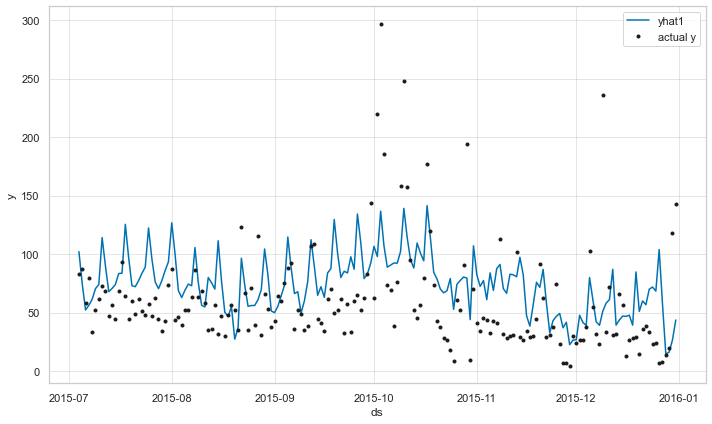

In [62]:
plot_test = m.plot(forecast_test)

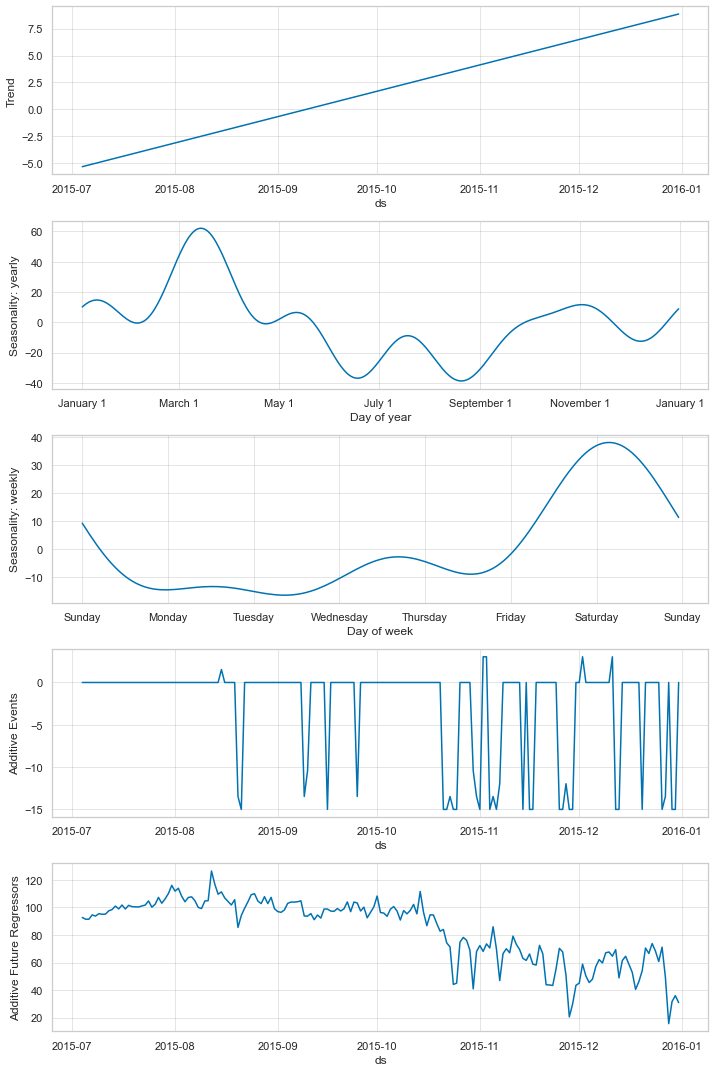

In [63]:
fig_comp = m.plot_components(forecast_test)

In [64]:
#To avoid reducing your forecast accuracy,  
#Always re-fit the model on all data available before actual prediction.
m = NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m, cols)
add_events(m, events)

model_5thb = m.fit(df_final_5thb, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.311% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 215


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.69E-02, min: 9.81E-01


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.69E-02, min: 4.95E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 4.17E-02
Epoch[215/215]: 100%|██████████| 215/215 [00:31<00:00,  6.77it/s, SmoothL1Loss=0.0396, MAE=25.8, RMSE=37.8, RegLoss=0]


In [65]:
#Future dataframe with 366 days in 2016 = df_5thb.
future = df_future


In [66]:
forecast_5thb = m.predict(future)
forecast_5thb

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Fog,event_Rain,...,future_regressor_Precipitation_Inches,future_regressor_TempAvg_F,future_regressor_TempHigh_F,future_regressor_TempLow_F,future_regressor_VisibilityAvg_Miles,future_regressor_VisibilityHigh_Miles,future_regressor_VisibilityLow_Miles,future_regressor_WindAvg_MPH,future_regressor_WindGust_MPH,future_regressor_WindHigh_MPH
0,2016-01-01,NaN,30.383425,NaN,30.030066,1.707330,1.095015,-15.184911,0.0,-15.184911,...,0.000000,9.194832,12.453219,-3.027181,8.945653,11.230606,-2.364052,-2.882418,-1.831845,-7.185843
1,2016-01-02,NaN,60.922714,NaN,30.156197,2.317473,33.257908,-15.184911,0.0,-15.184911,...,-0.849776,8.653960,11.674893,-2.751983,8.945653,11.230606,-2.364052,-0.411774,-0.488492,-1.596854
2,2016-01-03,NaN,53.610207,NaN,30.282326,2.851130,8.074957,-15.184911,0.0,-15.184911,...,0.000000,12.440066,23.349787,-2.614383,8.945653,11.230606,-2.364052,-0.823548,-0.610615,-2.395281
3,2016-01-04,NaN,48.053120,NaN,30.408457,3.304534,-13.818542,0.000000,0.0,0.000000,...,0.000000,10.276577,20.236481,-2.063987,8.945653,11.230606,-2.364052,-1.235322,-0.488492,-2.395281
4,2016-01-05,NaN,25.915110,NaN,30.534586,3.674775,-16.265024,-15.184911,0.0,-15.184911,...,0.000000,9.194832,18.679831,-1.926388,8.945653,11.230606,-2.364052,-0.823548,-0.366369,-2.395281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,NaN,104.682419,NaN,75.563034,-1.620559,-16.265024,0.000000,0.0,0.000000,...,0.000000,21.634901,34.246353,-5.503965,8.945653,11.230606,-2.364052,0.000000,-0.244246,-0.798427
362,2016-12-28,NaN,116.261131,NaN,75.689163,-0.744242,-8.486079,0.000000,0.0,0.000000,...,0.000000,23.798389,39.694637,-5.503965,7.827446,11.230606,-0.945621,-0.823548,-1.343353,-4.790561
363,2016-12-29,NaN,103.388489,NaN,75.815292,0.079517,-3.858236,0.000000,0.0,0.000000,...,0.000000,16.767046,29.576395,-3.715176,8.945653,11.230606,-2.364052,-3.294192,-2.564582,-9.581122
364,2016-12-30,NaN,111.293335,NaN,75.941429,0.844075,1.095015,0.000000,0.0,0.000000,...,0.000000,12.440066,17.901501,-3.715176,8.945653,11.230606,-2.364052,-1.235322,-0.854861,-4.790561


In [67]:
(forecast_5thb.yhat1.values < 0).sum()

0

In [68]:
#Storing forecast 
def get_predicted(station: str, forecast):
    #copy cell ds and yhat1
    predicted = forecast[['ds','yhat1']]
    #convert ds to datetime
    predicted['ds'] = pd.to_datetime(predicted['ds'])
    #split 'ds' into month and day columns
    month =predicted['ds'].dt.month
    predicted.insert(1,'month',month)
    day = predicted['ds'].dt.day
    predicted.insert(2,'day',day)
    #create a column for station name
    predicted.loc[:, 'start_station_name'] = station
    #rename predicted revenue 'yhat1'
    predicted = predicted.rename(columns={'yhat1':'revenue'})
    #drop date column
    predicted = predicted.drop(['ds'], axis=1)
    #get months[1, 3, 7, 10] into a dataframe
    predicted1 = predicted[predicted['month'] == 1]   #Jan
    predicted3 = predicted[predicted['month'] == 3]   #Mar
    predicted7 = predicted[predicted['month'] == 7]   #Jul
    predicted10 = predicted[predicted['month'] == 10] #Oct
    months = [predicted1, predicted3, predicted7, predicted10] 
    #Merging dataframes
    predicted = pd.concat(months)
    predicted = predicted.reset_index(drop=True)
    return predicted

get_pred_5thb = get_predicted('5th & Bowie',forecast_5thb)
get_pred_5thb 

WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-600a384d8254>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted['ds'] = pd.to_datetime(predicted['ds'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be

,month,day,revenue,start_station_name
0,1,1,30.383425,5th & Bowie
1,1,2,60.922714,5th & Bowie
2,1,3,53.610207,5th & Bowie
3,1,4,48.053120,5th & Bowie
4,1,5,25.915110,5th & Bowie
...,...,...,...,...
119,10,27,129.035446,5th & Bowie
120,10,28,129.968414,5th & Bowie
121,10,29,160.951767,5th & Bowie
122,10,30,137.807343,5th & Bowie


In [111]:
#Storing predicted values
def pred(station:str, get_pred):
    pred = pd.read_csv('predictions.csv', names=[
                        'month','day','start_station_name','revenue'],
                        index_col=False)
    pred1 = pred.drop('revenue', axis=1)
    pred_b = pred1[pred1['start_station_name']==station]
    revenue = get_pred['revenue']
    pred_b = pred_b.reset_index(drop=True)
    pred_b.insert(3, 'revenue', revenue)
    return pred_b

pred_5thb = pred('5th & Bowie', get_pred_5thb) 
pred_5thb

,month,day,start_station_name,revenue
0,1,1,5th & Bowie,30.383425
1,1,2,5th & Bowie,60.922714
2,1,3,5th & Bowie,53.610207
3,1,4,5th & Bowie,48.053120
4,1,5,5th & Bowie,25.915110
...,...,...,...,...
119,10,27,5th & Bowie,129.035446
120,10,28,5th & Bowie,129.968414
121,10,29,5th & Bowie,160.951767
122,10,30,5th & Bowie,137.807343


# 2nd & Congress

In [71]:
#Creating a dataframe with the function 
def station(station: str):
    df_bike_st = df_bike[df_bike['start_station_name'] == station].reset_index(drop=True)
    df_bike_st = df_bike_st.rename(columns={'date':'Date'})
    df_final = df_weather.merge(df_bike_st, how='inner')
    df_final = df_final.rename(columns={'Date':'ds','revenue':'y'})
    df_final = df_final.drop(columns={'Year','Month','year','month','day','start_station_name'})
    return df_final
df_final_2ndc = station('2nd & Congress')
df_final_2ndc

,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y
0,2014-01-01,69,54,39,83.0,68.0,52.0,10.0,10.0,8.0,13.0,4.0,22.0,0.00,0.0,0.0,0.0,0.0,115.9
1,2014-01-02,55,44,33,83.0,55.0,26.0,10.0,10.0,9.0,21.0,8.0,31.0,0.00,0.0,0.0,0.0,0.0,61.0
2,2014-01-03,58,43,28,75.0,49.0,22.0,10.0,10.0,10.0,14.0,4.0,21.0,0.00,0.0,0.0,0.0,0.0,3.4
3,2014-01-04,71,57,42,89.0,68.0,47.0,10.0,10.0,8.0,16.0,7.0,28.0,0.00,0.0,0.0,0.0,0.0,9.2
4,2014-01-06,36,29,22,50.0,38.0,26.0,10.0,10.0,10.0,17.0,7.0,27.0,0.00,0.0,0.0,0.0,0.0,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,2015-12-26,78,74,70,93.0,85.0,76.0,10.0,9.0,5.0,21.0,10.0,31.0,0.10,0.0,1.0,0.0,0.0,28.4
717,2015-12-28,46,41,36,92.0,75.0,58.0,10.0,10.0,10.0,21.0,8.0,35.0,0.00,0.0,0.0,0.0,0.0,5.7
718,2015-12-29,49,43,37,92.0,74.0,56.0,10.0,8.0,3.0,8.0,3.0,11.0,0.03,0.0,1.0,0.0,0.0,56.8
719,2015-12-30,57,49,41,100.0,80.0,59.0,10.0,7.0,3.0,9.0,4.0,14.0,0.00,0.0,1.0,0.0,0.0,72.4


In [72]:
#Modeling
m2 =NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m2, cols)
add_events(m2, events)

df_train2, df_test2 = m2.split_df(df_final_2ndc, valid_p=0.25)
model2 = m2.fit(df_train2, freq='D')
model2

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.613% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.521% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 239


  0%|          | 0/120 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.12E-01, min: 5.38E-01


  0%|          | 0/120 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.34E-01, min: 5.38E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.15E-01
Epoch[239/239]: 100%|██████████| 239/239 [00:29<00:00,  8.22it/s, SmoothL1Loss=0.0385, MAE=37.9, RMSE=51.9, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,1.338658,347.493564,429.277455,0.0
1,1.140284,307.372161,383.109904,0.0
2,0.991033,276.557569,346.282954,0.0
3,0.879322,252.568804,315.892137,0.0
4,0.789011,232.888418,291.540364,0.0
...,...,...,...,...
234,0.038582,37.857437,52.252002,0.0
235,0.038562,37.858664,51.848045,0.0
236,0.038561,37.878370,52.425916,0.0
237,0.038548,37.859180,51.258099,0.0


In [73]:
metrics_test2 = m2.test(df_test2)
metrics_test2

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.050 43.355 63.632


,SmoothL1Loss,MAE,RMSE
0,0.050347,43.354568,63.632057


In [74]:
# Re-fitting the model to increase accuracy
m2 = NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m2, cols)
add_events(m2, events)

model_2ndc = m2.fit(df_final_2ndc, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.613% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 216


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.49E-01, min: 4.95E-01


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.49E-01, min: 2.49E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.31E-01
Epoch[216/216]: 100%|██████████| 216/216 [00:32<00:00,  6.58it/s, SmoothL1Loss=0.0376, MAE=39.1, RMSE=52.7, RegLoss=0]


In [75]:
#Future dataframe with 366 days in 2016.
future2 = df_future

In [76]:
forecast_2ndc = m2.predict(future2)
forecast_2ndc

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Fog,event_Rain,...,future_regressor_Precipitation_Inches,future_regressor_TempAvg_F,future_regressor_TempHigh_F,future_regressor_TempLow_F,future_regressor_VisibilityAvg_Miles,future_regressor_VisibilityHigh_Miles,future_regressor_VisibilityLow_Miles,future_regressor_WindAvg_MPH,future_regressor_WindGust_MPH,future_regressor_WindHigh_MPH
0,2016-01-01,NaN,24.522017,NaN,18.299448,-11.719541,10.305917,-25.097322,0.0,-25.097322,...,0.000000,-4.746672,18.358562,9.080128,34.860828,4.26451,-13.847057,-3.031071,-11.787919,8.177494
1,2016-01-02,NaN,79.456055,NaN,18.194578,-11.386746,66.009064,-25.097322,0.0,-25.097322,...,-0.270711,-4.467456,17.211153,8.254662,34.860828,4.26451,-13.847057,-0.433010,-3.143445,1.817221
2,2016-01-03,NaN,61.829700,NaN,18.089706,-11.140744,31.101936,-25.097322,0.0,-25.097322,...,0.000000,-6.421968,34.422306,7.841928,34.860828,4.26451,-13.847057,-0.866020,-3.929307,2.725832
3,2016-01-04,NaN,29.277290,NaN,17.984829,-10.982744,-25.099792,0.000000,0.0,0.000000,...,0.000000,-5.305104,29.832663,6.190996,34.860828,4.26451,-13.847057,-1.299030,-3.143445,2.725832
4,2016-01-05,NaN,-8.502892,NaN,17.879957,-10.912896,-33.781990,-25.097322,0.0,-25.097322,...,0.000000,-4.746672,27.537846,5.778263,34.860828,4.26451,-13.847057,-0.866020,-2.357584,2.725832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,NaN,2.216281,NaN,-19.559338,-14.031804,-33.781990,0.000000,0.0,0.000000,...,0.000000,-11.168640,50.486050,16.509323,34.860828,4.26451,-13.847057,0.000000,-1.571723,0.908611
362,2016-12-28,NaN,13.261280,NaN,-19.664204,-13.366806,-30.757786,0.000000,0.0,0.000000,...,0.000000,-12.285504,58.517918,16.509323,30.503223,4.26451,-5.538823,-0.866020,-8.644474,5.451663
363,2016-12-29,NaN,8.346273,NaN,-19.769079,-12.772469,-17.777336,0.000000,0.0,0.000000,...,0.000000,-8.655696,43.601585,11.143793,34.860828,4.26451,-13.847057,-3.464081,-16.503086,10.903326
364,2016-12-30,NaN,31.571527,NaN,-19.873957,-12.254082,10.305917,0.000000,0.0,0.000000,...,0.000000,-6.421968,26.390432,11.143793,34.860828,4.26451,-13.847057,-1.299030,-5.501029,5.451663


In [77]:
(forecast_2ndc.yhat1.values < 0).sum()

44

In [78]:
#Replace negative values with 0
forecast_2ndc.yhat1 = forecast_2ndc.yhat1.clip(lower=0)
(forecast_2ndc.yhat1.values < 0).sum()

0

In [79]:
#store forecast
get_pred_2ndc = get_predicted('2nd & Congress', forecast_2ndc) 
#storing predicted values
pred_2ndc = pred('2nd & Congress', get_pred_2ndc) 
pred_2ndc

WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-600a384d8254>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted['ds'] = pd.to_datetime(predicted['ds'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be

,month,day,start_station_name,revenue
0,1,1,2nd & Congress,24.522017
1,1,2,2nd & Congress,79.456055
2,1,3,2nd & Congress,61.829700
3,1,4,2nd & Congress,29.277290
4,1,5,2nd & Congress,0.000000
...,...,...,...,...
119,10,27,2nd & Congress,72.137840
120,10,28,2nd & Congress,98.014565
121,10,29,2nd & Congress,151.990860
122,10,30,2nd & Congress,122.015266


# 8th & Congress

In [80]:
#Creating a dataframe with the function 
def station(station: str):
    df_bike_st = df_bike[df_bike['start_station_name'] == station].reset_index(drop=True)
    df_bike_st = df_bike_st.rename(columns={'date':'Date'})
    df_final = df_weather.merge(df_bike_st, how='inner')
    df_final = df_final.rename(columns={'Date':'ds','revenue':'y'})
    df_final = df_final.drop(columns={'Year','Month','year','month','day','start_station_name'})
    return df_final
df_final_8thc = station('8th & Congress')
df_final_8thc

,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y
0,2014-01-01,69,54,39,83.0,68.0,52.0,10.0,10.0,8.0,13.0,4.0,22.0,0.00,0.0,0.0,0.0,0.0,129.6
1,2014-01-02,55,44,33,83.0,55.0,26.0,10.0,10.0,9.0,21.0,8.0,31.0,0.00,0.0,0.0,0.0,0.0,42.3
2,2014-01-03,58,43,28,75.0,49.0,22.0,10.0,10.0,10.0,14.0,4.0,21.0,0.00,0.0,0.0,0.0,0.0,12.7
3,2014-01-04,71,57,42,89.0,68.0,47.0,10.0,10.0,8.0,16.0,7.0,28.0,0.00,0.0,0.0,0.0,0.0,28.8
4,2014-01-06,36,29,22,50.0,38.0,26.0,10.0,10.0,10.0,17.0,7.0,27.0,0.00,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2015-12-26,78,74,70,93.0,85.0,76.0,10.0,9.0,5.0,21.0,10.0,31.0,0.10,0.0,1.0,0.0,0.0,35.8
708,2015-12-28,46,41,36,92.0,75.0,58.0,10.0,10.0,10.0,21.0,8.0,35.0,0.00,0.0,0.0,0.0,0.0,22.7
709,2015-12-29,49,43,37,92.0,74.0,56.0,10.0,8.0,3.0,8.0,3.0,11.0,0.03,0.0,1.0,0.0,0.0,9.7
710,2015-12-30,57,49,41,100.0,80.0,59.0,10.0,7.0,3.0,9.0,4.0,14.0,0.00,0.0,1.0,0.0,0.0,27.8


In [81]:
#Modeling
m3 =NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m3, cols)
add_events(m3, events)

df_train3, df_test3 = m3.split_df(df_final_8thc, valid_p=0.25)
model = m3.fit(df_train3, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.753% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.753% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 240


  0%|          | 0/120 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.59E-01, min: 3.80E-01


  0%|          | 0/120 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.59E-01, min: 3.80E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.36E-01
Epoch[240/240]: 100%|██████████| 240/240 [00:29<00:00,  8.22it/s, SmoothL1Loss=0.0615, MAE=29.1, RMSE=47.5, RegLoss=0]


In [82]:
metrics_test3 = m3.test(df_test3)
metrics_test3

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.191% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.059 26.802 62.292


,SmoothL1Loss,MAE,RMSE
0,0.05902,26.802258,62.292423


In [83]:
# Re-fitting the model to increase accuracy
m3 = NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m3, cols)
add_events(m3, events)

model_8thc = m3.fit(df_final_8thc, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.753% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 217


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.77E-01, min: 4.95E-01


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.10E-01, min: 5.87E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.55E-01
Epoch[217/217]: 100%|██████████| 217/217 [00:31<00:00,  6.84it/s, SmoothL1Loss=0.0632, MAE=27.7, RMSE=45.7, RegLoss=0]


In [84]:
#Future dataframe with 366 days in 2016 
future3 = df_future

In [85]:
forecast_8thc = m3.predict(future3)
forecast_8thc

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Fog,event_Rain,...,future_regressor_Precipitation_Inches,future_regressor_TempAvg_F,future_regressor_TempHigh_F,future_regressor_TempLow_F,future_regressor_VisibilityAvg_Miles,future_regressor_VisibilityHigh_Miles,future_regressor_VisibilityLow_Miles,future_regressor_WindAvg_MPH,future_regressor_WindGust_MPH,future_regressor_WindHigh_MPH
0,2016-01-01,NaN,14.296559,NaN,-16.971525,6.686923,2.246018,-2.795415,0.0,-2.795415,...,0.000000,6.956724,9.017789,-8.992826,24.654821,14.858172,-10.431661,-2.63942,3.997398,-8.633097
1,2016-01-02,NaN,21.053217,NaN,-17.067724,6.739174,16.548262,-2.795415,0.0,-2.795415,...,-0.873231,6.547505,8.266306,-8.175296,24.654821,14.858172,-10.431661,-0.37706,1.065973,-1.918466
2,2016-01-03,NaN,33.444275,NaN,-17.163925,6.718644,14.237550,-2.795415,0.0,-2.795415,...,0.000000,9.412038,19.538542,-7.766531,24.654821,14.858172,-10.431661,-0.75412,1.332466,-2.877699
3,2016-01-04,NaN,21.158443,NaN,-17.260124,6.623138,-2.479292,0.000000,0.0,0.000000,...,0.000000,7.775162,16.532612,-6.131472,24.654821,14.858172,-10.431661,-1.13118,1.065973,-2.877699
4,2016-01-05,NaN,6.629762,NaN,-17.356323,6.451144,-11.878184,-2.795415,0.0,-2.795415,...,0.000000,6.956724,15.029647,-5.722707,24.654821,14.858172,-10.431661,-0.75412,0.799480,-2.877699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,NaN,-14.702419,NaN,-51.699799,5.729949,-11.878184,0.000000,0.0,0.000000,...,0.000000,16.368763,30.059294,-16.350592,24.654821,14.858172,-10.431661,0.00000,0.532986,-0.959233
362,2016-12-28,NaN,-2.834152,NaN,-51.795998,6.052847,-9.540614,0.000000,0.0,0.000000,...,0.000000,18.005638,35.319672,-16.350592,21.572968,14.858172,-4.172665,-0.75412,2.931425,-5.755397
363,2016-12-29,NaN,-20.536247,NaN,-51.892197,6.318956,-9.133738,0.000000,0.0,0.000000,...,0.000000,12.685790,25.550400,-11.036649,24.654821,14.858172,-10.431661,-3.01648,5.596357,-11.510795
364,2016-12-30,NaN,-6.185220,NaN,-51.988403,6.523655,2.246018,0.000000,0.0,0.000000,...,0.000000,9.412038,14.278165,-11.036649,24.654821,14.858172,-10.431661,-1.13118,1.865453,-5.755397


In [86]:
(forecast_8thc.yhat1.values < 0).sum()

99

In [87]:
#Replace negative values with 0
forecast_8thc.yhat1 = forecast_8thc.yhat1.clip(lower=0)
(forecast_8thc.yhat1.values < 0).sum()

0

In [88]:
#store forecast
get_pred_8thc = get_predicted('8th & Congress', forecast_8thc) 

#storing predicted values
pred_8thc = pred('8th & Congress', get_pred_8thc) 
pred_8thc

WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-600a384d8254>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted['ds'] = pd.to_datetime(predicted['ds'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be

,month,day,start_station_name,revenue
0,1,1,8th & Congress,14.296559
1,1,2,8th & Congress,21.053217
2,1,3,8th & Congress,33.444275
3,1,4,8th & Congress,21.158443
4,1,5,8th & Congress,6.629762
...,...,...,...,...
119,10,27,8th & Congress,11.677761
120,10,28,8th & Congress,20.864450
121,10,29,8th & Congress,35.687508
122,10,30,8th & Congress,30.902668


# City Hall / Lavaca & 2nd

In [89]:
#Creating a dataframe with the function 
def station(station: str):
    df_bike_st = df_bike[df_bike['start_station_name'] == station].reset_index(drop=True)
    df_bike_st = df_bike_st.rename(columns={'date':'Date'})
    df_final = df_weather.merge(df_bike_st, how='inner')
    df_final = df_final.rename(columns={'Date':'ds','revenue':'y'})
    df_final = df_final.drop(columns={'Year','Month','year','month','day','start_station_name'})
    return df_final
df_final_cityh = station('City Hall / Lavaca & 2nd')
df_final_cityh


,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y
0,2014-01-01,69,54,39,83.0,68.0,52.0,10.0,10.0,8.0,13.0,4.0,22.0,0.00,0.0,0.0,0.0,0.0,207.0
1,2014-01-02,55,44,33,83.0,55.0,26.0,10.0,10.0,9.0,21.0,8.0,31.0,0.00,0.0,0.0,0.0,0.0,39.9
2,2014-01-03,58,43,28,75.0,49.0,22.0,10.0,10.0,10.0,14.0,4.0,21.0,0.00,0.0,0.0,0.0,0.0,4.9
3,2014-01-04,71,57,42,89.0,68.0,47.0,10.0,10.0,8.0,16.0,7.0,28.0,0.00,0.0,0.0,0.0,0.0,100.8
4,2014-01-05,59,47,34,87.0,59.0,31.0,10.0,10.0,4.0,21.0,10.0,34.0,0.00,0.0,0.0,0.0,0.0,12.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,2015-12-26,78,74,70,93.0,85.0,76.0,10.0,9.0,5.0,21.0,10.0,31.0,0.10,0.0,1.0,0.0,0.0,75.0
718,2015-12-28,46,41,36,92.0,75.0,58.0,10.0,10.0,10.0,21.0,8.0,35.0,0.00,0.0,0.0,0.0,0.0,10.6
719,2015-12-29,49,43,37,92.0,74.0,56.0,10.0,8.0,3.0,8.0,3.0,11.0,0.03,0.0,1.0,0.0,0.0,27.7
720,2015-12-30,57,49,41,100.0,80.0,59.0,10.0,7.0,3.0,9.0,4.0,14.0,0.00,0.0,1.0,0.0,0.0,138.1


In [90]:
#Modeling
m4 =NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m4, cols)
add_events(m4, events)

df_train4, df_test4 = m4.split_df(df_final_cityh, valid_p=0.25)
model4 = m4.fit(df_train4, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.892% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.077% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 239


  0%|          | 0/120 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.95E-02, min: 9.08E-01


  0%|          | 0/120 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.70E-02, min: 1.08E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.71E-02
Epoch[239/239]: 100%|██████████| 239/239 [00:18<00:00, 12.86it/s, SmoothL1Loss=0.0326, MAE=44.9, RMSE=65.5, RegLoss=0]


In [91]:
metrics_test4 = m4.test(df_test4)
metrics_test4

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.778% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.032 47.213 70.705


,SmoothL1Loss,MAE,RMSE
0,0.031565,47.212952,70.705383


In [92]:
# Re-fitting the model to increase accuracy
m4 = NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m4, cols)
add_events(m4, events)

model_cityh = m4.fit(df_final_cityh, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.892% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 216


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.49E-01, min: 3.51E-01


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.49E-01, min: 4.17E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.31E-01
Epoch[216/216]: 100%|██████████| 216/216 [00:20<00:00, 10.33it/s, SmoothL1Loss=0.0333, MAE=43.7, RMSE=63.3, RegLoss=0]


In [93]:
#Future dataframe with 366 days in 2016 = df_cityh.
future4 = df_future

In [94]:
forecast_cityh = m4.predict(future4)
forecast_cityh

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Fog,event_Rain,...,future_regressor_Precipitation_Inches,future_regressor_TempAvg_F,future_regressor_TempHigh_F,future_regressor_TempLow_F,future_regressor_VisibilityAvg_Miles,future_regressor_VisibilityHigh_Miles,future_regressor_VisibilityLow_Miles,future_regressor_WindAvg_MPH,future_regressor_WindGust_MPH,future_regressor_WindHigh_MPH
0,2016-01-01,NaN,38.910751,NaN,-27.607344,-3.125597,-3.293777,-17.75161,0.0,-17.75161,...,0.000000,-9.204142,21.847269,20.093805,15.123165,78.336166,-9.835085,-9.339954,32.246098,-43.020863
1,2016-01-02,NaN,109.930092,NaN,-27.452219,-1.788380,72.700645,-17.75161,0.0,-17.75161,...,-1.292772,-8.662723,20.481815,18.267096,15.123165,78.336166,-9.835085,-1.334279,8.598960,-9.560192
2,2016-01-03,NaN,100.016609,NaN,-27.297087,-0.551042,46.446350,-17.75161,0.0,-17.75161,...,0.000000,-12.452663,40.963631,17.353741,15.123165,78.336166,-9.835085,-2.668558,10.748699,-14.340288
3,2016-01-04,NaN,46.479740,NaN,-27.141956,0.580884,-25.481028,0.00000,0.0,0.00000,...,0.000000,-10.286983,35.501812,13.700322,15.123165,78.336166,-9.835085,-4.002838,8.598960,-14.340288
4,2016-01-05,NaN,20.248350,NaN,-26.986832,1.603070,-30.569046,-17.75161,0.0,-17.75161,...,0.000000,-9.204142,32.770905,12.786967,15.123165,78.336166,-9.835085,-2.668558,6.449219,-14.340288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,NaN,121.686005,NaN,28.394342,-9.748635,-30.569046,0.00000,0.0,0.00000,...,0.000000,-21.656807,60.079990,36.534191,15.123165,78.336166,-9.835085,0.000000,4.299480,-4.780096
362,2016-12-28,NaN,130.472198,NaN,28.549467,-8.073650,-32.034206,0.00000,0.0,0.00000,...,0.000000,-23.822485,69.638168,36.534191,13.232769,78.336166,-3.934034,-2.668558,23.647139,-28.680576
363,2016-12-29,NaN,98.281960,NaN,28.704590,-6.463270,-27.768951,0.00000,0.0,0.00000,...,0.000000,-16.784023,51.887260,24.660580,15.123165,78.336166,-9.835085,-10.674233,45.144535,-57.361153
364,2016-12-30,NaN,134.019302,NaN,28.859745,-4.927316,-3.293777,0.00000,0.0,0.00000,...,0.000000,-12.452663,31.405447,24.660580,15.123165,78.336166,-9.835085,-4.002838,15.048179,-28.680576


In [95]:
(forecast_cityh.yhat1.values < 0).sum()

0

In [96]:
#store forecast
get_pred_cityh = get_predicted('City Hall / Lavaca & 2nd', forecast_cityh) 

#storing predicted values
pred_cityh = pred('City Hall / Lavaca & 2nd', get_pred_cityh) 
pred_cityh

WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-600a384d8254>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted['ds'] = pd.to_datetime(predicted['ds'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be

,month,day,start_station_name,revenue
0,1,1,City Hall / Lavaca & 2nd,38.910751
1,1,2,City Hall / Lavaca & 2nd,109.930092
2,1,3,City Hall / Lavaca & 2nd,100.016609
3,1,4,City Hall / Lavaca & 2nd,46.479740
4,1,5,City Hall / Lavaca & 2nd,20.248350
...,...,...,...,...
119,10,27,City Hall / Lavaca & 2nd,142.828934
120,10,28,City Hall / Lavaca & 2nd,155.695618
121,10,29,City Hall / Lavaca & 2nd,242.673264
122,10,30,City Hall / Lavaca & 2nd,209.061310


# Convention Center / 3rd & Trinity


In [97]:
df_final_convc = station('Convention Center / 3rd & Trinity')
df_final_convc


,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y


In [98]:
df_bike['start_station_name'].unique()

array(['2nd & Congress', '4th & Congress', '5th & Bowie',
       '8th & Congress', 'Barton Springs & Riverside',
       'Capitol Station / Congress & 11th', 'City Hall / Lavaca & 2nd',
       'Convention Center / 4th St. @ MetroRail', 'Republic Square',
       'South Congress & Elizabeth', 'South Congress & James',
       'Main Office', '6th & Navasota St.', 'Waller & 6th St.',
       'West & 6th St.', '17th & Guadalupe', 'ACC - Rio Grande & 12th',
       'ACC - West & 12th', 'State Capitol @ 14th & Colorado',
       'Bullock Museum @ Congress & MLK', 'Guadalupe & 21st',
       'Long Center @ South 1st & Riverside',
       'State Parking Garage @ Brazos & 18th', 'UT West Mall @ Guadalupe',
       'Republic Square @ Guadalupe & 4th St.', '8th & Guadalupe',
       'Plaza Saltillo', 'Repair Shop', '3rd & West',
       'MapJam at Hops & Grain Brewery', 'Davis at Rainey Street',
       'Palmer Auditorium', 'San Jacinto & 8th Street',
       'South Congress & Academy', 'Riverside @ S. Lamar'

In [99]:
#Checking if this is a valid start_station_name
'Convention Center / 3rd & Trinity' in df_bike['start_station_name']
    

False

In [100]:
#Checking if this is a valid end_station_name
'Convention Center / 3rd & Trinity' in df_bike_orig['end_station_name']

False

Convention Center / 3rd & Trinity does not exist as a station name in our dataframe

In [112]:
#storing predicted values - float('NaN') for easy location
pred1 = pd.read_csv('predictions.csv', names=[
                    'month','day','start_station_name','revenue'],
                    index_col=False)
pred_convc = pred1[pred1['start_station_name']== 'Convention Center / 3rd & Trinity']
pred_convc = pred_convc.reset_index(drop=True)
pred_convc['revenue'] = 'NaN'
pred_convc

,month,day,start_station_name,revenue
0,1,1,Convention Center / 3rd & Trinity,NaN
1,1,2,Convention Center / 3rd & Trinity,NaN
2,1,3,Convention Center / 3rd & Trinity,NaN
3,1,4,Convention Center / 3rd & Trinity,NaN
4,1,5,Convention Center / 3rd & Trinity,NaN
...,...,...,...,...
119,10,27,Convention Center / 3rd & Trinity,NaN
120,10,28,Convention Center / 3rd & Trinity,NaN
121,10,29,Convention Center / 3rd & Trinity,NaN
122,10,30,Convention Center / 3rd & Trinity,NaN


# Davis at Rainey Street

In [102]:
#Creating a dataframe with the function 
df_final_davis = station('Davis at Rainey Street')
df_final_davis

,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y
0,2014-02-25,71,62,52,93.0,85.0,77.0,10.0,4.0,1.0,12.0,5.0,20.0,0.00,0.0,1.0,0.0,0.0,1.8
1,2014-02-26,52,44,36,83.0,63.0,43.0,10.0,8.0,2.0,20.0,8.0,29.0,0.11,0.0,1.0,0.0,0.0,1.8
2,2014-02-27,59,45,31,82.0,56.0,29.0,10.0,10.0,10.0,12.0,3.0,17.0,0.00,0.0,0.0,0.0,0.0,21.0
3,2014-02-28,80,62,44,83.0,60.0,37.0,10.0,10.0,7.0,13.0,6.0,21.0,0.00,0.0,0.0,0.0,0.0,34.9
4,2014-03-01,82,68,53,93.0,74.0,54.0,10.0,7.0,0.0,16.0,5.0,27.0,0.00,1.0,0.0,0.0,0.0,165.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,2015-12-26,78,74,70,93.0,85.0,76.0,10.0,9.0,5.0,21.0,10.0,31.0,0.10,0.0,1.0,0.0,0.0,76.7
648,2015-12-27,73,55,36,93.0,89.0,84.0,10.0,8.0,1.0,21.0,10.0,33.0,1.32,0.0,1.0,0.0,1.0,7.0
649,2015-12-29,49,43,37,92.0,74.0,56.0,10.0,8.0,3.0,8.0,3.0,11.0,0.03,0.0,1.0,0.0,0.0,32.5
650,2015-12-30,57,49,41,100.0,80.0,59.0,10.0,7.0,3.0,9.0,4.0,14.0,0.00,0.0,1.0,0.0,0.0,6.1


In [103]:
#Modeling
m6 =NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m6, cols)
add_events(m6, events)

df_train6, df_test6 = m6.split_df(df_final_davis, valid_p=0.25)
model6 = m6.fit(df_train6, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.626% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.933% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 248


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.90E-02, min: 1.80E-01


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.46E-02, min: 2.14E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.72E-02
Epoch[248/248]: 100%|██████████| 248/248 [00:16<00:00, 14.85it/s, SmoothL1Loss=0.0375, MAE=44.1, RMSE=70.2, RegLoss=0]


In [104]:
metrics_test6 = m6.test(df_test6)
metrics_test6

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.092% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.042 67.500 78.984


,SmoothL1Loss,MAE,RMSE
0,0.041578,67.499763,78.983704


In [105]:
# Re-fitting the model to increase accuracy
m6 = NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m6, cols)
add_events(m6, events)

model_davis = m6.fit(df_final_davis, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.626% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 224


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 4.73E-01


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.19E-01, min: 4.73E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.06E-01
Epoch[224/224]: 100%|██████████| 224/224 [00:19<00:00, 11.59it/s, SmoothL1Loss=0.0433, MAE=39.6, RMSE=62.8, RegLoss=0]


In [106]:
future6 =df_future

In [107]:
forecast_davis = m6.predict(future6)
forecast_davis

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Fog,event_Rain,...,future_regressor_Precipitation_Inches,future_regressor_TempAvg_F,future_regressor_TempHigh_F,future_regressor_TempLow_F,future_regressor_VisibilityAvg_Miles,future_regressor_VisibilityHigh_Miles,future_regressor_VisibilityLow_Miles,future_regressor_WindAvg_MPH,future_regressor_WindGust_MPH,future_regressor_WindHigh_MPH
0,2016-01-01,NaN,28.967941,NaN,-79.823067,29.116051,11.084925,-7.889447,0.0,-7.889447,...,0.000000,2.387882,18.474895,3.052038,69.816864,16.729753,-21.290483,6.558924,-6.901672,-14.647288
1,2016-01-02,NaN,65.837410,NaN,-79.828812,30.464823,53.267017,-7.889447,0.0,-7.889447,...,0.190054,2.188892,16.935322,2.746834,69.816864,16.729753,-21.290483,0.936989,-1.840446,-3.254953
2,2016-01-03,NaN,70.241852,NaN,-79.834549,31.646183,33.817726,-7.889447,0.0,-7.889447,...,0.000000,3.581823,40.028942,2.594232,69.816864,16.729753,-21.290483,1.873978,-2.300558,-4.882430
3,2016-01-04,NaN,23.222961,NaN,-79.840294,32.648964,-22.228764,0.000000,0.0,0.000000,...,0.000000,2.785862,33.870644,1.983825,69.816864,16.729753,-21.290483,2.810968,-1.840446,-4.882430
4,2016-01-05,NaN,2.695297,NaN,-79.846039,33.463688,-33.103634,-7.889447,0.0,-7.889447,...,0.000000,2.387882,30.791492,1.831223,69.816864,16.729753,-21.290483,1.873978,-1.380334,-4.882430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,NaN,30.428207,NaN,-81.895988,21.836555,-33.103634,0.000000,0.0,0.000000,...,0.000000,6.964655,61.582985,5.798872,69.816864,16.729753,-21.290483,0.000000,-0.920223,-1.627477
362,2016-12-28,NaN,52.184376,NaN,-81.901733,23.739202,-22.438087,0.000000,0.0,0.000000,...,0.000000,7.760616,72.360001,5.798872,61.089752,16.729753,-8.516194,1.873978,-5.061226,-9.764860
363,2016-12-29,NaN,15.667919,NaN,-81.907471,25.537285,-20.399179,0.000000,0.0,0.000000,...,0.000000,5.173744,52.345539,3.815047,69.816864,16.729753,-21.290483,7.495914,-9.662341,-19.529720
364,2016-12-30,NaN,53.089737,NaN,-81.913216,27.214153,11.084925,0.000000,0.0,0.000000,...,0.000000,3.581823,29.251917,3.815047,69.816864,16.729753,-21.290483,2.810968,-3.220780,-9.764860


In [108]:
(forecast_davis.yhat1.values < 0).sum()

58

In [109]:
#Replace negative values with 0
forecast_davis.yhat1 = forecast_davis.yhat1.clip(lower=0)
(forecast_davis.yhat1.values < 0).sum()

0

In [113]:
#store forecast
get_pred_davis = get_predicted('Davis at Rainey Street', forecast_davis) 

#storing predicted values
pred_davis = pred('Davis at Rainey Street', get_pred_davis) 
pred_davis

WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-600a384d8254>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted['ds'] = pd.to_datetime(predicted['ds'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be

,month,day,start_station_name,revenue
0,1,1,Davis at Rainey Street,28.967941
1,1,2,Davis at Rainey Street,65.837410
2,1,3,Davis at Rainey Street,70.241852
3,1,4,Davis at Rainey Street,23.222961
4,1,5,Davis at Rainey Street,2.695297
...,...,...,...,...
119,10,27,Davis at Rainey Street,45.249786
120,10,28,Davis at Rainey Street,68.591789
121,10,29,Davis at Rainey Street,111.387459
122,10,30,Davis at Rainey Street,97.219658


# Guadalupe & 21st

In [114]:
#Creating a dataframe with the function 
df_final_guada = station('Guadalupe & 21st')
df_final_guada

,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y
0,2014-02-01,76,66,55,81.0,71.0,60.0,10.0,10.0,9.0,14.0,6.0,26.0,0.00,0.0,1.0,0.0,0.0,45.0
1,2014-02-03,46,40,34,82.0,74.0,65.0,10.0,6.0,3.0,13.0,6.0,17.0,0.00,0.0,0.0,0.0,0.0,2.4
2,2014-02-04,64,53,42,89.0,68.0,46.0,10.0,6.0,2.0,10.0,2.0,18.0,0.15,0.0,1.0,0.0,0.0,11.9
3,2014-02-05,48,40,31,80.0,60.0,39.0,10.0,10.0,10.0,16.0,10.0,24.0,0.00,0.0,0.0,0.0,0.0,1.9
4,2014-02-06,32,29,26,58.0,54.0,49.0,10.0,10.0,10.0,15.0,8.0,23.0,0.00,0.0,0.0,0.0,0.0,6.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,2015-12-26,78,74,70,93.0,85.0,76.0,10.0,9.0,5.0,21.0,10.0,31.0,0.10,0.0,1.0,0.0,0.0,21.3
637,2015-12-28,46,41,36,92.0,75.0,58.0,10.0,10.0,10.0,21.0,8.0,35.0,0.00,0.0,0.0,0.0,0.0,3.1
638,2015-12-29,49,43,37,92.0,74.0,56.0,10.0,8.0,3.0,8.0,3.0,11.0,0.03,0.0,1.0,0.0,0.0,26.4
639,2015-12-30,57,49,41,100.0,80.0,59.0,10.0,7.0,3.0,9.0,4.0,14.0,0.00,0.0,1.0,0.0,0.0,22.5


In [115]:
#Modeling
m7 =NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m7, cols)
add_events(m7, events)

df_train7, df_test7 = m7.split_df(df_final_guada, valid_p=0.25)
model7 = m7.fit(df_train7, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.42% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 90.644% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 250


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.14E-01, min: 3.04E-01


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.55E-01, min: 7.32E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.76E-01
Epoch[250/250]: 100%|██████████| 250/250 [00:15<00:00, 15.67it/s, SmoothL1Loss=0.0596, MAE=19.8, RMSE=29.2, RegLoss=0]


In [116]:
metrics_test7 = m7.test(df_test7)
metrics_test7

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 93.75% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.055 17.122 31.464


,SmoothL1Loss,MAE,RMSE
0,0.055324,17.121729,31.464331


In [117]:
# Re-fitting the model to increase accuracy
m7 = NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m7, cols)
add_events(m7, events)

model_guada = m7.fit(df_final_guada, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 91.42% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 225


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.08E-02, min: 1.33E+00


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.41E-02, min: 3.35E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.41E-02
Epoch[225/225]: 100%|██████████| 225/225 [00:18<00:00, 11.89it/s, SmoothL1Loss=0.06, MAE=19, RMSE=28, RegLoss=0]      


In [118]:
#Future dataframe with 366 days in 2016
future7 = df_future

In [119]:
forecast_guada = m7.predict(future7)
forecast_guada

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Fog,event_Rain,...,future_regressor_Precipitation_Inches,future_regressor_TempAvg_F,future_regressor_TempHigh_F,future_regressor_TempLow_F,future_regressor_VisibilityAvg_Miles,future_regressor_VisibilityHigh_Miles,future_regressor_VisibilityLow_Miles,future_regressor_WindAvg_MPH,future_regressor_WindGust_MPH,future_regressor_WindHigh_MPH
0,2016-01-01,NaN,17.823589,NaN,-1.314118,0.869317,5.536266,-0.469049,0.0,-0.469049,...,0.000000,-4.298736,0.904524,12.359195,9.823141,2.483624,4.630819,-3.689612,-4.902300,-0.318145
1,2016-01-02,NaN,43.202564,NaN,-1.353919,1.134427,20.650284,-0.469049,0.0,-0.469049,...,-0.336962,-4.045869,0.847991,11.123275,9.823141,2.483624,4.630819,-0.527087,-1.307280,-0.070699
2,2016-01-03,NaN,29.883299,NaN,-1.393719,1.364259,7.707047,-0.469049,0.0,-0.469049,...,0.000000,-5.815937,1.695982,10.505315,9.823141,2.483624,4.630819,-1.054175,-1.634100,-0.106048
3,2016-01-04,NaN,13.041442,NaN,-1.433520,1.557461,-7.096552,0.000000,0.0,0.000000,...,0.000000,-4.804469,1.469851,8.033476,9.823141,2.483624,4.630819,-1.581262,-1.307280,-0.106048
4,2016-01-05,NaN,8.486193,NaN,-1.473320,1.713131,-9.844610,-0.469049,0.0,-0.469049,...,0.000000,-4.298736,1.356786,7.415516,9.823141,2.483624,4.630819,-1.054175,-0.980460,-0.106048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,NaN,7.637071,NaN,-15.682211,-0.602248,-9.844610,0.000000,0.0,0.000000,...,0.000000,-10.114672,2.487440,23.482468,9.823141,2.483624,4.630819,0.000000,-0.653640,-0.035349
362,2016-12-28,NaN,-3.388167,NaN,-15.722012,-0.211736,-11.091331,0.000000,0.0,0.000000,...,0.000000,-11.126140,2.883170,23.482468,8.595248,2.483624,1.852328,-1.054175,-3.595020,-0.212096
363,2016-12-29,NaN,-0.368273,NaN,-15.761812,0.153696,-5.861104,0.000000,0.0,0.000000,...,0.000000,-7.838871,2.148244,15.448993,9.823141,2.483624,4.630819,-4.216700,-6.863221,-0.424193
364,2016-12-30,NaN,13.206445,NaN,-15.801613,0.491068,5.536266,0.000000,0.0,0.000000,...,0.000000,-5.815937,1.300253,15.448993,9.823141,2.483624,4.630819,-1.581262,-2.287740,-0.212096


In [120]:
(forecast_guada.yhat1.values < 0).sum()

66

In [121]:
#Replace negative values with 0
forecast_guada.yhat1 = forecast_guada.yhat1.clip(lower=0)
(forecast_guada.yhat1.values < 0).sum()

0

In [122]:
#store forecast
get_pred_guada = get_predicted('Guadalupe & 21st', forecast_guada) 

#storing predicted values
pred_guada = pred('Guadalupe & 21st', get_pred_guada) 
pred_guada

WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-600a384d8254>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted['ds'] = pd.to_datetime(predicted['ds'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be

,month,day,start_station_name,revenue
0,1,1,Guadalupe & 21st,17.823589
1,1,2,Guadalupe & 21st,43.202564
2,1,3,Guadalupe & 21st,29.883299
3,1,4,Guadalupe & 21st,13.041442
4,1,5,Guadalupe & 21st,8.486193
...,...,...,...,...
119,10,27,Guadalupe & 21st,14.391251
120,10,28,Guadalupe & 21st,23.648035
121,10,29,Guadalupe & 21st,38.505455
122,10,30,Guadalupe & 21st,31.167364


# South Congress & Academy

In [123]:
#Creating a dataframe with the function 
df_final_south = station('South Congress & Academy')
df_final_south

,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y
0,2014-02-25,71,62,52,93.0,85.0,77.0,10.0,4.0,1.0,12.0,5.0,20.0,0.00,0.0,1.0,0.0,0.0,1.8
1,2014-02-26,52,44,36,83.0,63.0,43.0,10.0,8.0,2.0,20.0,8.0,29.0,0.11,0.0,1.0,0.0,0.0,12.7
2,2014-02-27,59,45,31,82.0,56.0,29.0,10.0,10.0,10.0,12.0,3.0,17.0,0.00,0.0,0.0,0.0,0.0,1.9
3,2014-02-28,80,62,44,83.0,60.0,37.0,10.0,10.0,7.0,13.0,6.0,21.0,0.00,0.0,0.0,0.0,0.0,98.2
4,2014-03-01,82,68,53,93.0,74.0,54.0,10.0,7.0,0.0,16.0,5.0,27.0,0.00,1.0,0.0,0.0,0.0,37.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,2015-12-27,73,55,36,93.0,89.0,84.0,10.0,8.0,1.0,21.0,10.0,33.0,1.32,0.0,1.0,0.0,1.0,2.5
651,2015-12-28,46,41,36,92.0,75.0,58.0,10.0,10.0,10.0,21.0,8.0,35.0,0.00,0.0,0.0,0.0,0.0,6.8
652,2015-12-29,49,43,37,92.0,74.0,56.0,10.0,8.0,3.0,8.0,3.0,11.0,0.03,0.0,1.0,0.0,0.0,41.1
653,2015-12-30,57,49,41,100.0,80.0,59.0,10.0,7.0,3.0,9.0,4.0,14.0,0.00,0.0,1.0,0.0,0.0,26.6


In [124]:
#Modeling
m8 =NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m8, cols)
add_events(m8, events)

df_train8, df_test8 = m8.split_df(df_final_south, valid_p=0.25)
model8 = m8.fit(df_train8, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.099% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.341% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 247


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.26E-01, min: 1.80E-01


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.90E-02, min: 3.63E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.04E-01
Epoch[247/247]: 100%|██████████| 247/247 [00:15<00:00, 15.75it/s, SmoothL1Loss=0.0307, MAE=26.7, RMSE=37.2, RegLoss=0]


In [125]:
metrics_test8 = m8.test(df_test8)
metrics_test8

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 98.773% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.054 40.578 53.045


,SmoothL1Loss,MAE,RMSE
0,0.05354,40.577625,53.044762


In [126]:
# Re-fitting the model to increase accuracy
m8 = NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m8, cols)
add_events(m8, events)

model_south = m8.fit(df_final_south, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.099% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 223


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.00E-01, min: 4.73E-01


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.68E-01, min: 3.98E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.50E-01
Epoch[223/223]: 100%|██████████| 223/223 [00:18<00:00, 11.89it/s, SmoothL1Loss=0.0353, MAE=25.7, RMSE=36.8, RegLoss=0]


In [127]:
#Future dataframe with 366 days in 2016 = df_2ndc.
future8 = df_future

In [128]:
forecast_south= m8.predict(future8)
forecast_south

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Fog,event_Rain,...,future_regressor_Precipitation_Inches,future_regressor_TempAvg_F,future_regressor_TempHigh_F,future_regressor_TempLow_F,future_regressor_VisibilityAvg_Miles,future_regressor_VisibilityHigh_Miles,future_regressor_VisibilityLow_Miles,future_regressor_WindAvg_MPH,future_regressor_WindGust_MPH,future_regressor_WindHigh_MPH
0,2016-01-01,NaN,25.378990,NaN,-8.497423,-1.582187,4.822778,-11.970091,0.0,-11.970091,...,0.000000,-5.728444,10.043834,4.938453,32.864822,25.828659,-12.933585,-1.753644,8.215816,-12.109255
1,2016-01-02,NaN,47.338928,NaN,-8.582065,-1.523668,42.832111,-11.970091,0.0,-11.970091,...,-0.726073,-5.370416,9.206848,4.468124,32.864822,25.828659,-12.933585,-0.250521,2.190884,-2.690946
2,2016-01-03,NaN,30.434917,NaN,-8.666710,-1.521943,16.241758,-11.970091,0.0,-11.970091,...,0.000000,-7.876609,21.761641,4.232960,32.864822,25.828659,-12.933585,-0.501041,2.738605,-4.036418
3,2016-01-04,NaN,21.531967,NaN,-8.751351,-1.579006,-9.066845,0.000000,0.0,0.000000,...,0.000000,-6.444499,18.413696,3.292302,32.864822,25.828659,-12.933585,-0.751562,2.190884,-4.036418
4,2016-01-05,NaN,-1.495182,NaN,-8.835992,-1.696167,-18.200394,-11.970091,0.0,-11.970091,...,0.000000,-5.728444,16.739723,3.057137,32.864822,25.828659,-12.933585,-0.501041,1.643163,-4.036418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,NaN,-11.145770,NaN,-39.053200,-2.392487,-18.200394,0.000000,0.0,0.000000,...,0.000000,-13.963081,33.479446,9.171412,32.864822,25.828659,-12.933585,0.000000,1.095442,-1.345473
362,2016-12-28,NaN,-3.031707,NaN,-39.137848,-2.128820,-19.487953,0.000000,0.0,0.000000,...,0.000000,-15.395193,39.338352,9.171412,28.756720,25.828659,-5.173434,-0.501041,6.024932,-8.072837
363,2016-12-29,NaN,-19.042070,NaN,-39.222485,-1.906911,-17.141453,0.000000,0.0,0.000000,...,0.000000,-10.740831,28.457531,6.114275,32.864822,25.828659,-12.933585,-2.004165,11.502143,-16.145674
364,2016-12-30,NaN,16.958302,NaN,-39.307129,-1.731134,4.822778,0.000000,0.0,0.000000,...,0.000000,-7.876609,15.902738,6.114275,32.864822,25.828659,-12.933585,-0.751562,3.834048,-8.072837


In [129]:
(forecast_south.yhat1.values < 0).sum()

75

In [130]:
#Replace negative values with 0
forecast_south.yhat1 = forecast_south.yhat1.clip(lower=0)
(forecast_south.yhat1.values < 0).sum()

0

In [131]:
#store forecast
get_pred_south = get_predicted('South Congress & Academy', forecast_south) 

#storing predicted values
pred_south = pred('South Congress & Academy', get_pred_south) 
pred_south

WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-600a384d8254>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted['ds'] = pd.to_datetime(predicted['ds'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be

,month,day,start_station_name,revenue
0,1,1,South Congress & Academy,25.378990
1,1,2,South Congress & Academy,47.338928
2,1,3,South Congress & Academy,30.434917
3,1,4,South Congress & Academy,21.531967
4,1,5,South Congress & Academy,0.000000
...,...,...,...,...
119,10,27,South Congress & Academy,11.856103
120,10,28,South Congress & Academy,31.431433
121,10,29,South Congress & Academy,72.862175
122,10,30,South Congress & Academy,40.466610


# West & 6th St.

In [132]:
#Creating a dataframe with the function 
df_final_west = station('West & 6th St.')
df_final_west

,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y
0,2014-01-29,49,38,27,63.0,42.0,21.0,10.0,10.0,10.0,15.0,5.0,23.0,0.00,0.0,0.0,0.0,0.0,2.2
1,2014-01-30,65,48,31,80.0,64.0,48.0,10.0,10.0,10.0,15.0,7.0,27.0,0.00,0.0,0.0,0.0,0.0,3.1
2,2014-01-31,80,68,55,86.0,64.0,42.0,10.0,10.0,9.0,14.0,9.0,25.0,0.00,0.0,0.0,0.0,0.0,5.2
3,2014-02-01,76,66,55,81.0,71.0,60.0,10.0,10.0,9.0,14.0,6.0,26.0,0.00,0.0,1.0,0.0,0.0,71.9
4,2014-02-03,46,40,34,82.0,74.0,65.0,10.0,6.0,3.0,13.0,6.0,17.0,0.00,0.0,0.0,0.0,0.0,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,2015-12-27,73,55,36,93.0,89.0,84.0,10.0,8.0,1.0,21.0,10.0,33.0,1.32,0.0,1.0,0.0,1.0,2.0
676,2015-12-28,46,41,36,92.0,75.0,58.0,10.0,10.0,10.0,21.0,8.0,35.0,0.00,0.0,0.0,0.0,0.0,25.6
677,2015-12-29,49,43,37,92.0,74.0,56.0,10.0,8.0,3.0,8.0,3.0,11.0,0.03,0.0,1.0,0.0,0.0,30.6
678,2015-12-30,57,49,41,100.0,80.0,59.0,10.0,7.0,3.0,9.0,4.0,14.0,0.00,0.0,1.0,0.0,0.0,8.5


In [133]:
#Modeling
m9 =NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m9, cols)
add_events(m9, events)

df_train9, df_test9 = m9.split_df(df_final_west, valid_p=0.25)
model9 = m9.fit(df_train9, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.059% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 244


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.90E-02, min: 3.63E-01


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.90E-02, min: 1.26E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 9.25E-02
Epoch[244/244]: 100%|██████████| 244/244 [00:16<00:00, 15.14it/s, SmoothL1Loss=0.0564, MAE=22.7, RMSE=35.9, RegLoss=0]


In [134]:
metrics_test9 = m9.test(df_test9)
metrics_test9

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.647% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.093 24.282 83.959


,SmoothL1Loss,MAE,RMSE
0,0.093245,24.281591,83.959068


In [135]:
# Re-fitting the model to increase accuracy
m9 = NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m9, cols)
add_events(m9, events)

model_west = m9.fit(df_final_west, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 97.059% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 220


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.06E-01, min: 3.51E-01


  0%|          | 0/122 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.26E-01, min: 3.51E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.10E-01
Epoch[220/220]: 100%|██████████| 220/220 [00:19<00:00, 11.56it/s, SmoothL1Loss=0.0692, MAE=22.6, RMSE=39.2, RegLoss=0]


In [136]:
#Future dataframe with 366 days in 2016 
future9 = df_future

In [137]:
forecast_west = m9.predict(future9)
forecast_west

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Fog,event_Rain,...,future_regressor_Precipitation_Inches,future_regressor_TempAvg_F,future_regressor_TempHigh_F,future_regressor_TempLow_F,future_regressor_VisibilityAvg_Miles,future_regressor_VisibilityHigh_Miles,future_regressor_VisibilityLow_Miles,future_regressor_WindAvg_MPH,future_regressor_WindGust_MPH,future_regressor_WindHigh_MPH
0,2016-01-01,NaN,8.710369,NaN,-12.700432,0.008782,-1.843322,-6.902129,0.0,-6.902129,...,0.000000,8.643970,-0.278543,-2.891409,25.761986,17.51333,-7.210568,-11.157151,4.372050,-2.399248
1,2016-01-02,NaN,33.809383,NaN,-12.777871,-0.092270,21.758829,-6.902129,0.0,-6.902129,...,-0.314518,8.103723,-0.255331,-2.616037,25.761986,17.51333,-7.210568,-1.593879,1.165880,-0.533166
2,2016-01-03,NaN,27.424765,NaN,-12.855324,-0.252905,12.960111,-6.902129,0.0,-6.902129,...,0.000000,11.885459,-0.603510,-2.478351,25.761986,17.51333,-7.210568,-3.187757,1.457350,-0.799749
3,2016-01-04,NaN,12.068306,NaN,-12.932775,-0.473898,-8.334470,0.000000,0.0,0.000000,...,0.000000,9.724466,-0.510662,-1.927606,25.761986,17.51333,-7.210568,-4.781636,1.165880,-0.799749
4,2016-01-05,NaN,3.253710,NaN,-13.010215,-0.755355,-10.010069,-6.902129,0.0,-6.902129,...,0.000000,8.643970,-0.464238,-1.789920,25.761986,17.51333,-7.210568,-3.187757,0.874410,-0.799749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,NaN,-7.627141,NaN,-40.659031,-0.182032,-10.010069,0.000000,0.0,0.000000,...,0.000000,21.069677,-0.928477,-5.369760,25.761986,17.51333,-7.210568,0.000000,0.582940,-0.266583
362,2016-12-28,NaN,-3.415985,NaN,-40.736481,-0.052939,-7.706449,0.000000,0.0,0.000000,...,0.000000,23.230671,-1.090960,-5.369760,22.081703,17.51333,-2.884228,-3.187757,3.206170,-1.599499
363,2016-12-29,NaN,-15.990940,NaN,-40.813927,0.026679,-6.824628,0.000000,0.0,0.000000,...,0.000000,16.207445,-0.789205,-3.579840,25.761986,17.51333,-7.210568,-12.751030,6.120871,-3.198997
364,2016-12-30,NaN,-3.088215,NaN,-40.891373,0.053539,-1.843322,0.000000,0.0,0.000000,...,0.000000,11.885459,-0.441027,-3.579840,25.761986,17.51333,-7.210568,-4.781636,2.040290,-1.599499


In [138]:
(forecast_west.yhat1.values < 0).sum()

111

In [139]:
#Replace negative values with 0
forecast_west.yhat1 = forecast_west.yhat1.clip(lower=0)
(forecast_west.yhat1.values < 0).sum()

0

In [140]:
#store forecast
get_pred_west = get_predicted('West & 6th St.', forecast_west) 

#storing predicted values
pred_west = pred('West & 6th St.', get_pred_west) 
pred_west

WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-600a384d8254>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted['ds'] = pd.to_datetime(predicted['ds'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be

,month,day,start_station_name,revenue
0,1,1,West & 6th St.,8.710369
1,1,2,West & 6th St.,33.809383
2,1,3,West & 6th St.,27.424765
3,1,4,West & 6th St.,12.068306
4,1,5,West & 6th St.,3.253710
...,...,...,...,...
119,10,27,West & 6th St.,10.546026
120,10,28,West & 6th St.,16.668480
121,10,29,West & 6th St.,42.263924
122,10,30,West & 6th St.,30.783911


# 17th & Guadalupe

In [141]:
#Creating a dataframe with the function 
df_final_17thg = station('17th & Guadalupe')
df_final_17thg

,ds,TempHigh_F,TempAvg_F,TempLow_F,HumidityHigh_Percent,HumidityAvg_Percent,HumidityLow_Percent,VisibilityHigh_Miles,VisibilityAvg_Miles,VisibilityLow_Miles,WindHigh_MPH,WindAvg_MPH,WindGust_MPH,Precipitation_Inches,Fog,Rain,Snow,Thunderstorm,y
0,2014-01-30,65,48,31,80.0,64.0,48.0,10.0,10.0,10.0,15.0,7.0,27.0,0.00,0.0,0.0,0.0,0.0,8.7
1,2014-01-31,80,68,55,86.0,64.0,42.0,10.0,10.0,9.0,14.0,9.0,25.0,0.00,0.0,0.0,0.0,0.0,19.9
2,2014-02-01,76,66,55,81.0,71.0,60.0,10.0,10.0,9.0,14.0,6.0,26.0,0.00,0.0,1.0,0.0,0.0,57.7
3,2014-02-02,55,45,35,79.0,69.0,59.0,10.0,8.0,4.0,18.0,11.0,29.0,0.02,0.0,1.0,0.0,0.0,4.6
4,2014-02-03,46,40,34,82.0,74.0,65.0,10.0,6.0,3.0,13.0,6.0,17.0,0.00,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,2015-12-24,74,63,52,93.0,81.0,68.0,10.0,9.0,4.0,10.0,1.0,16.0,0.00,0.0,0.0,0.0,0.0,16.0
654,2015-12-28,46,41,36,92.0,75.0,58.0,10.0,10.0,10.0,21.0,8.0,35.0,0.00,0.0,0.0,0.0,0.0,10.8
655,2015-12-29,49,43,37,92.0,74.0,56.0,10.0,8.0,3.0,8.0,3.0,11.0,0.03,0.0,1.0,0.0,0.0,4.8
656,2015-12-30,57,49,41,100.0,80.0,59.0,10.0,7.0,3.0,9.0,4.0,14.0,0.00,0.0,1.0,0.0,0.0,16.9


In [142]:
#Modeling
m0 =NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m0, cols)
add_events(m0, events)

df_train0, df_test0 = m0.split_df(df_final_17thg, valid_p=0.25)
model0 = m0.fit(df_train0, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.137% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 94.332% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 247


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.15E-01, min: 1.04E+00


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.14E-01, min: 8.72E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.23E-01
Epoch[247/247]: 100%|██████████| 247/247 [00:16<00:00, 15.30it/s, SmoothL1Loss=0.0652, MAE=16.3, RMSE=26.5, RegLoss=0]


In [143]:
metrics_test0 = m0.test(df_test0)
metrics_test0

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.951% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.153 28.141 68.283


,SmoothL1Loss,MAE,RMSE
0,0.152748,28.14064,68.283363


In [144]:
# Re-fitting the model to increase accuracy
m0 = NeuralProphet(daily_seasonality=False, yearly_seasonality=True)

add_regressors(m0, cols)
add_events(m0, events)

model_17thg = m0.fit(df_final_17thg, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.137% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 223


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.68E-01, min: 7.94E-01


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.41E-01, min: 3.98E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.33E-01
Epoch[223/223]: 100%|██████████| 223/223 [00:18<00:00, 11.80it/s, SmoothL1Loss=0.0739, MAE=17.8, RMSE=31.8, RegLoss=0]


In [145]:
#Future dataframe with 366 days in 2016 = df_2ndc.
future0 = df_future

In [146]:
forecast_17thg = m0.predict(future0)
forecast_17thg

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.727% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,events_additive,event_Fog,event_Rain,...,future_regressor_Precipitation_Inches,future_regressor_TempAvg_F,future_regressor_TempHigh_F,future_regressor_TempLow_F,future_regressor_VisibilityAvg_Miles,future_regressor_VisibilityHigh_Miles,future_regressor_VisibilityLow_Miles,future_regressor_WindAvg_MPH,future_regressor_WindGust_MPH,future_regressor_WindHigh_MPH
0,2016-01-01,NaN,24.800390,NaN,0.475145,6.642371,5.523457,-3.355325,0.0,-3.355325,...,0.000000,5.075120,2.095699,2.636081,18.242651,1.141386,-3.980006,-11.817844,3.304940,-2.525676
1,2016-01-02,NaN,35.261875,NaN,0.509821,7.121843,12.949426,-3.355325,0.0,-3.355325,...,-0.340445,4.776583,1.964718,2.385026,18.242651,1.141386,-3.980006,-1.688264,0.881317,-0.561261
2,2016-01-03,NaN,31.346161,NaN,0.544501,7.542458,6.430239,-3.355325,0.0,-3.355325,...,0.000000,6.866339,3.929436,2.259498,18.242651,1.141386,-3.980006,-3.376527,1.101647,-0.841892
3,2016-01-04,NaN,24.040909,NaN,0.579182,7.901869,-2.794139,0.000000,0.0,0.000000,...,0.000000,5.672193,3.405511,1.757387,18.242651,1.141386,-3.980006,-5.064791,0.881317,-0.841892
4,2016-01-05,NaN,14.976105,NaN,0.613862,8.198344,-10.188249,-3.355325,0.0,-3.355325,...,0.000000,5.075120,3.143549,1.631860,18.242651,1.141386,-3.980006,-3.376527,0.660988,-0.841892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-12-27,NaN,39.985909,NaN,12.994271,4.026016,-10.188249,0.000000,0.0,0.000000,...,0.000000,11.941459,5.763173,4.895579,18.242651,1.141386,-3.980006,0.000000,0.440659,-0.280631
362,2016-12-28,NaN,44.795860,NaN,13.028948,4.716605,-7.104391,0.000000,0.0,0.000000,...,0.000000,13.135604,6.680042,4.895579,15.962319,1.141386,-1.592002,-3.376527,2.423623,-1.683784
363,2016-12-29,NaN,28.846310,NaN,13.063627,5.364381,-4.816340,0.000000,0.0,0.000000,...,0.000000,9.254630,4.977286,3.263720,18.242651,1.141386,-3.980006,-13.506108,4.626916,-3.367568
364,2016-12-30,NaN,49.670204,NaN,13.098307,5.964762,5.523457,0.000000,0.0,0.000000,...,0.000000,6.866339,3.012568,3.263720,18.242651,1.141386,-3.980006,-5.064791,1.542305,-1.683784


In [147]:
(forecast_17thg.yhat1.values < 0).sum()

0

In [148]:
#store forecast
get_pred_17thg = get_predicted('17th & Guadalupe', forecast_17thg) 

#storing predicted values
pred_17thg = pred('17th & Guadalupe', get_pred_17thg) 
pred_17thg

WARNING - (py.warnings._showwarnmsg) - <ipython-input-68-600a384d8254>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted['ds'] = pd.to_datetime(predicted['ds'])

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value

WARNING - (py.warnings._showwarnmsg) - C:\Users\essej\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be

,month,day,start_station_name,revenue
0,1,1,17th & Guadalupe,24.800390
1,1,2,17th & Guadalupe,35.261875
2,1,3,17th & Guadalupe,31.346161
3,1,4,17th & Guadalupe,24.040909
4,1,5,17th & Guadalupe,14.976105
...,...,...,...,...
119,10,27,17th & Guadalupe,42.522968
120,10,28,17th & Guadalupe,53.715763
121,10,29,17th & Guadalupe,62.749249
122,10,30,17th & Guadalupe,54.036255


# Predictions to csv

In [163]:
feed = [pred_2ndc, pred_5thb, pred_8thc, pred_cityh, 
        pred_convc, pred_davis, pred_guada, 
        pred_south, pred_west, pred_17thg]

result = pd.concat(feed)
result = result.sort_values(by=['month', 'day'])
result

,month,day,start_station_name,revenue
0,1,1,2nd & Congress,24.522017
0,1,1,5th & Bowie,30.383425
0,1,1,8th & Congress,14.296559
0,1,1,City Hall / Lavaca & 2nd,38.910751
0,1,1,Convention Center / 3rd & Trinity,NaN
...,...,...,...,...
123,10,31,Davis at Rainey Street,50.01429
123,10,31,Guadalupe & 21st,7.378272
123,10,31,South Congress & Academy,20.797747
123,10,31,West & 6th St.,11.896017


In [159]:
result.to_csv('predictions', index=False, header=False)
result.to_csv(r'C:\Users\essej\Desktop\predictions.csv')

# Conclusion

We were able to use NeuralProphet to forecast revenue using weather components and events as feature variables. 

# Recommendations. 
1. For temperatue highs in range(90,105) and relative humidity high > 80%, change event to extreme heat advisory.
2. For temperature lows < 31, change event to frostbite advisory since the weather frostbite advisory is in range (33-36). 
3. Possible Windchills and Relative humidity calculations.
4. Possibly model all stations simultaneously.

# Honor Code Statement
The work I have submitted is entirely my own and I have strictly adhered to the specified honor code.